# Strangulation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle
import pynbody
pynbody.config['halo-class-priority'] =  [pynbody.halo.ahf.AHFCatalogue,
                                          pynbody.halo.GrpCatalogue,
                                          pynbody.halo.AmigaGrpCatalogue,
                                          pynbody.halo.legacy.RockstarIntermediateCatalogue,
                                          pynbody.halo.rockstar.RockstarCatalogue,
                                          pynbody.halo.subfind.SubfindCatalogue, pynbody.halo.hop.HOPCatalogue]

%matplotlib inline
print(mpl.get_backend())
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

module://ipykernel.pylab.backend_inline


In [5]:
def read_file(name, halo_num):
    data = []
    with open('/home/akinshol/Data/Timescales/DataFiles/'+name+'.data','rb') as f:
        while True:
            try: 
                data.append(pickle.load(f))
            except EOFError:
                break
    data = pd.DataFrame(data)
    
    if not halo_num=='all':
        data = data[data.z0haloid == halo_num]

    return data

def cumulative_sfh(name, halo_num):
    age = 13.800797497330507
    if name=='h148':
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/h148.cosmo50PLK.3072g3HbwK1BH.004096')
    else:
        s = pynbody.load('/home/christenc/Data/Sims/'+name+'.cosmo50PLK.3072g/'+name+'.cosmo50PLK.3072gst5HbwK1BH/snapshots/'+name+'.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise

    sfhmstar = np.sum(sfh)
    bincenters = 0.5*(bins[1:]+bins[:-1])
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar 
    return c_sfh, age-bincenters

def sfh(name, halo_num):
    age = 13.800797497330507
    if name=='h148':
        s = pynbody.load('/home/christenc/Data/Sims/h148.cosmo50PLK.3072g/h148.cosmo50PLK.3072g3HbwK1BH/snapshots/h148.cosmo50PLK.3072g3HbwK1BH.004096')
    else:
        s = pynbody.load('/home/christenc/Data/Sims/'+name+'.cosmo50PLK.3072g/'+name+'.cosmo50PLK.3072gst5HbwK1BH/snapshots/'+name+'.cosmo50PLK.3072gst5HbwK1BH.004096')
    halo = s.halos()[halo_num]
    try:
        sfh, bins = pynbody.plot.stars.sfh(halo, filename=None, massform=False, clear=False, legend=False, subplot=False, trange=False, bins=128)
        plt.clf()
    except ValueError:
        print(f'Cannot create SFH, only {len(halo.s)} star particles')
        raise
    
    bincenters = 0.5*(bins[1:]+bins[:-1])

    return sfh, age-bincenters

In [6]:
def CaseStudyPlots(simulation_name,i,showram=True,filename=True):

    data = read_file(simulation_name, i)
    # data[:10]

    age = 13.800797497330507
    q_thresh = 0.9
    i_thresh = 1.0
    
    print('Gathering data...')
    time = age - np.array(data['time'], dtype=float)
    gasfrac = np.array(data['gasfrac'], dtype=float)
    gastemp = np.array(data['gtemp'], dtype=float)
    ratio = np.array(data['ratio'], dtype=float)
    dist = np.array(data['h1dist'], dtype=float)
    SNHf = np.array(data['SNHfrac'], dtype=float)
    fHI = np.array(data['fHI'], dtype=float)
    mvir = np.array(data['mass'], dtype=float)
    HIratio = np.array(data['HIratio'], dtype=float)
    mHI = np.array(data['HIratio'],dtype=float)*np.array(data['mstar'],dtype=float)
    mgas = np.array(data['mgas'],dtype=float)
    c_sfh, bc = cumulative_sfh(simulation_name, i)

    shaded_min = -1
    shaded_max = 500*np.max(mgas)

    fig, ax = plt.subplots(1,1,figsize=(4,4), dpi=100)
    ax.plot(time,dist,'g-')
    ax.invert_xaxis()
    ax.set_xlabel('Lookback Time [Gyr]')
    label3 = ax.set_ylabel(r'Distance from Host [$R_{\mathrm{vir}}$]')
    label3.set_color('g')
    ax.semilogy()
    ax.set_xlim(14,0)
    ax.set_ylim(0.1, 25)

    ax1 = ax.twinx()
    ax1.plot(time,ratio,'m-')
    label4 = ax1.set_ylabel(r'$P_{\mathrm{ram}} / P_{\mathrm{rest}}$')
    label4.set_color('m')
    ax1.set_ylim(np.min(ratio[~np.isnan(ratio)])-0.3, np.max(ratio[~np.isnan(ratio)])+1)
    npeaks = 1
    peak_indices = np.argsort(ratio[~np.isnan(ratio)])[-npeaks:]


    ax.fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for index in peak_indices:
        t = time[~np.isnan(ratio)][index]
        ax.plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)

    if showram:
        plt.show()

    fig, ax = plt.subplots(1,3,figsize=(18,4),dpi=300)
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min, shaded_max, where=(dist < 1), edgecolor='none',alpha=0.2, facecolor='g')

    for i in [0,1,2]:
        for index in peak_indices:
            t = time[~np.isnan(ratio)][index]
            ax[i].plot([t,t],[shaded_min,shaded_max], 'm--', linewidth=1)


    ax[0].plot(bc, c_sfh, 'r-')
    ax[0].invert_xaxis()
    ax[0].set_xlabel('Lookback Time [Gyr]')
    label1 = ax[0].set_ylabel('Cumulative, Normalized SFH')
    label1.set_color('r')
    ax[0].set_ylim(-0.05,1.05)
    ax[0].set_xlim(14,0)

    ax0 = ax[0].twinx()
    ax0.plot(time,HIratio,'b-')
    ax0.set_ylim(-1,10)
    label2 = ax0.set_ylabel(r'$M_{\mathrm{HI}}\ /\ M_{*}$')
    label2.set_color('b')
    t = np.max(bc[c_sfh >= 0.99])

    for i in [0,1,2]:
        ax[i].plot([t,t],[shaded_min,shaded_max], 'r--', linewidth=1)


    ax[1].plot(time,mHI,color='#370ec2',label='HI', linestyle='-')
    ax[1].plot(time,mgas,color='#370ec2',label='All Gas', linestyle='--')
    ax[1].set_xlabel('Lookback Time [Gyr]')
    label = ax[1].set_ylabel(r'Gas Mass [$M_{\odot}$]')
    label.set_color('#370ec2')
    ax[1].legend(frameon=False)
    ax[1].semilogy()
    ax[1].invert_xaxis()
    ax[1].set_xlim(14,0)
    allgas = np.append(mgas,mHI)
    allgas = allgas[(~np.isnan(allgas)) & (allgas!=0)]
    ax[1].set_ylim(0.5*np.min(allgas),1.4*np.max(allgas))

    ax1 = ax[1].twinx()
    ax1.plot(time,gastemp,'k-')
    ax1.invert_xaxis()
    ax1.set_xlabel('Lookback Time [Gyr]')
    ax1.set_ylabel('Mean Gas Temperature [K]')
    ax1.set_xlim(14,0)
    ax1.set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.05*np.max(gastemp[~np.isnan(gastemp)]))

    # ax[2].set_ylim(0.85*np.min(gastemp[~np.isnan(gastemp)]), 1.4*np.max(gastemp[~np.isnan(gastemp)]))
    # ax[2].plot(time,data['outflow_temp_23'],label='Outflow')
    # ax[2].plot(time,data['inflow_temp_23'],label='Inflow')
    # ax[2].legend(frameon=False, prop={'size':9})
    # ax[2].semilogy()


    netflux = data['outflow_91'] + data['inflow_91']
    # ax[2].plot(time, netflux, color='#ad7617', linestyle='-')
    # ax[2].invert_xaxis()
    # label5 = ax[2].set_ylabel(r'Net Gas Flux [$M_{\mathrm{\odot}}\ \mathrm{yr}^{-1}$]')
    # label5.set_color('#ad7617')
    # ax[2].set_ylim(1.2*np.min(netflux),1.2*np.max(netflux))
    for i in [0,1,2]:
        ax[i].fill_between(time, shaded_min,shaded_max, where=(netflux < 0.), edgecolor='none',alpha=0.2, facecolor='#ad7617')

    ax[2].invert_xaxis()
    ax[2].plot(time,abs(data['outflow_91']), color='r',label='outflow')
    ax[2].plot(time,abs(data['inflow_91']), color='orange', label='inflow')
    ax[2].set_ylabel('Outflow Rate / Inflow Rate')
    ax[2].legend(frameon=False)
    alloutflows = np.append(abs(data['outflow_91']),abs(data['inflow_91']))
    alloutflows = alloutflows[~np.isnan(alloutflows)]

    if (alloutflows == 0.).all():
        ax[2].set_ylim(-0.001,0.001)
    else:
        ax[2].set_ylim(-0.001,1.3*np.max(alloutflows))
    ax[2].set_xlim(14,0)

    ax2 = ax[2].twinx()
    ax2.plot(time,SNHf, c='b')
    label = ax2.set_ylabel('SN Heated Fraction')
    label.set_color('b')


    plt.subplots_adjust(wspace=0.45)
    if filename:
        f = 'case_study_'+str(simulation_name)+'_'+str(i)+'.png'
        plt.savefig('CaseStudyPlots/'+f, dpi=300)
    else:
        plt.savefig('CaseStudyPlots/'+str(filename), dpi=300)
    plt.show()

### Proof of Concept

First we test this concept on halo 21 of h242. We want to look at the gas-depletion timescales, to see if a model in which HI loss is driven purely by star formation can account for the observed quenching time.

Gathering data...


<Figure size 432x288 with 0 Axes>

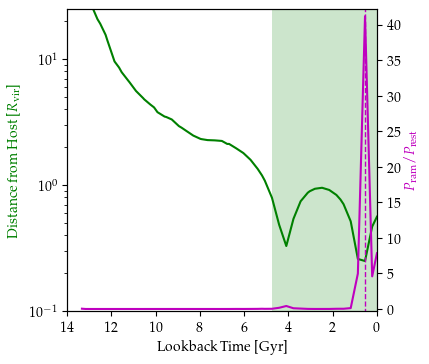

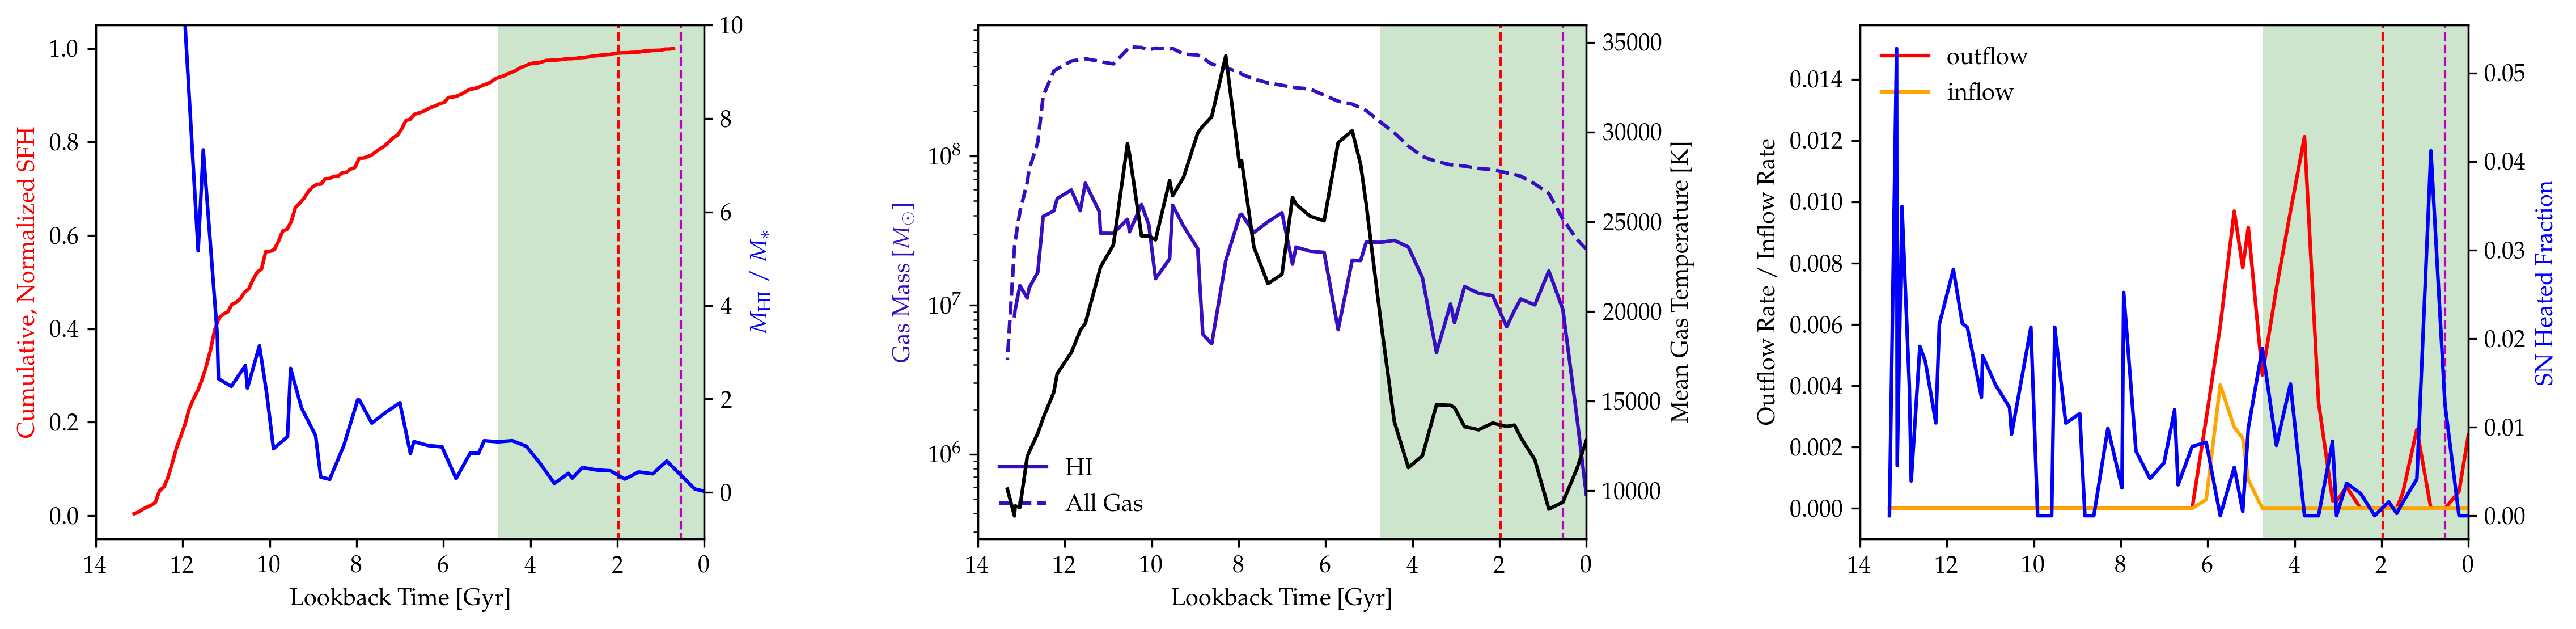

In [178]:
CaseStudyPlots('h242',48)

In [179]:
data = read_file('h242',48)
c_sfh, bc = cumulative_sfh('h242',48)

<Figure size 432x288 with 0 Axes>

First, we get the quenching time, defined as the point at which the halo forms 99% if its present day stellar mass. 

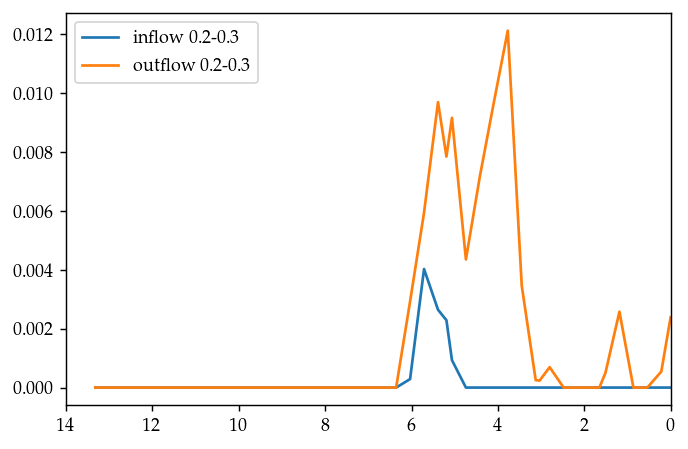

In [182]:
plt.figure(dpi=130)
plt.plot(age - data.time, np.abs(data.inflow_91), label='inflow 0.2-0.3')
plt.plot(age - data.time, np.abs(data.outflow_91), label='outflow 0.2-0.3')
plt.xlim(14,0)
plt.legend()
plt.show()

In [186]:
age = 13.800797497330507
tquench = age - np.max(bc[c_sfh > 0.99])
print(f'Quenching time {tquench:.2f} Gyr')

Quenching time 11.82 Gyr


Now, we compute the atomic hydrogen depletion times at various timesteps through the star formation history. That is, at every snapshot post-reionization but prior to the quenching time, we compute the instantanous atomic hydrogen gas depletion time $M_{\mathrm{HI}}/\mathrm{SFR}$. 

In [196]:
time_until_quench = np.array(tquench - data.time) # this array is exactly what it says it is -- the time until the quenching epoch, for each timestep
sfr = np.array(data.sfr[(time_until_quench > 0)&(data.time > 2.2)], dtype=float) 
# the star formation rate at each snapshot post-reionization and prior to quenching
mHI = np.array(data.mHI[(time_until_quench > 0)&(data.time > 2.2)], dtype=float)
Mout = np.array(data.outflow_91[(time_until_quench > 0)&(data.time > 2.2)], dtype=float)
Mout23 = np.array(data.outflow_23[(time_until_quench > 0)&(data.time > 2.2)], dtype=float) 
Min23 = np.array(data.inflow_23[(time_until_quench > 0)&(data.time > 2.2)], dtype=float)
Mnet = Mout23 + Min23

In [198]:
HI_depletion_times = mHI / sfr / 1e9 # divide by 1e9 since we want depletion times in Gyr and SFR is given in Msol/yr
print(HI_depletion_times)
loss_timescale = mHI / (Mout +  sfr) / 1e9
print(loss_timescale)

[ 85.29663233  19.36141484  27.43257951 112.07536633  16.81714515
          inf 223.92561473  22.20999557  16.04411189   8.65131359
  18.14481209  26.43858479   7.69409962 103.42856642  13.82272324
  18.39856431  42.90784164   3.97960336  19.78453054  17.92590797
  17.93573265   6.34970152  21.33577208   8.31514875          inf
  49.29426495   4.53037119  10.55893288   8.5789178  155.70819248
 230.14085347   2.56942887   7.68725544   5.92431732   8.54910956
   5.71450952   1.95011287   2.35217087   7.81744399]
[ 85.29663233  19.36141484  11.30102076  24.90251927  11.8749935
   1.38867606   1.25435791   2.27833208   3.0665954    3.56586721
   2.49468699   2.31993917   1.62744427   1.14000725   4.95908506
  18.39856431  42.90784164   3.97960336  19.78453054  17.92590797
  17.93573265   6.34970152  21.33577208   8.31514875          inf
  49.29426495   4.53037119  10.55893288   8.5789178  155.70819248
 230.14085347   2.56942887   7.68725544   5.92431732   8.54910956
   5.71450952   1.95011

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


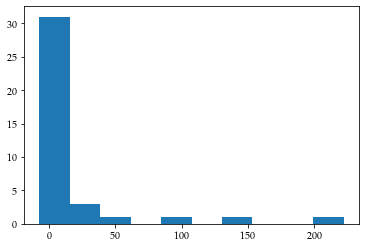

In [205]:
plt.hist(np.array(loss_timescale)[~np.isinf(loss_timescale)] - time_until_quench_slice[~np.isinf(loss_timescale)])
plt.show()

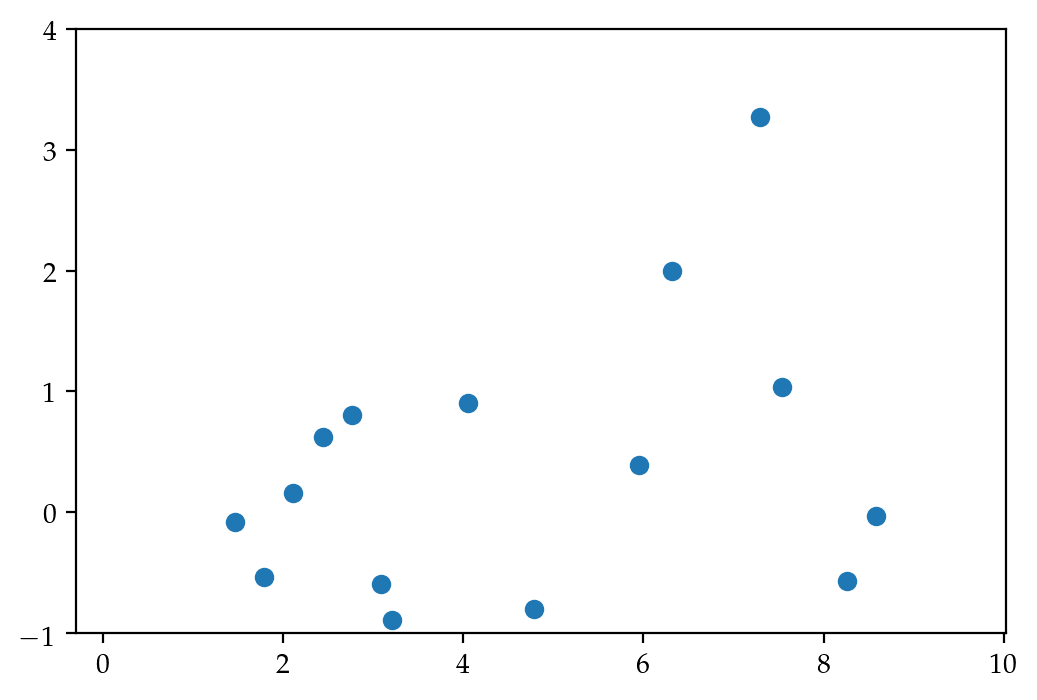

In [201]:
time_until_quench_slice = time_until_quench[(time_until_quench > 0)&(data.time > 2.2)] 

plt.figure(dpi=200)
plt.scatter(time_until_quench_slice, loss_timescale - time_until_quench_slice)
plt.ylim(-1,4)
plt.show()

Now, consider the following. If quenching was driven purely by strangulation, we would expect that at each timestep, the time until quenching would be roughly equivalent to the instantanous HI depletion timescale. So, we would expect that the mean difference between the HI depletion timescale and the time until quenching would be not different from 0. So, let's test that!

In [170]:
time_until_quench_slice = time_until_quench[(time_until_quench > 0)&(data.time > 2.2)] # get a specific slice of the time until quench, post-reionization and pre-quench
mean = np.mean(HI_depletion_times - time_until_quench_slice)
std = np.std(HI_depletion_times - time_until_quench_slice)
print(f'HI depletion - time until quench, {mean:.2f} ± {std:.2f}')

HI depletion - time until quench, 10.01 ± 7.89


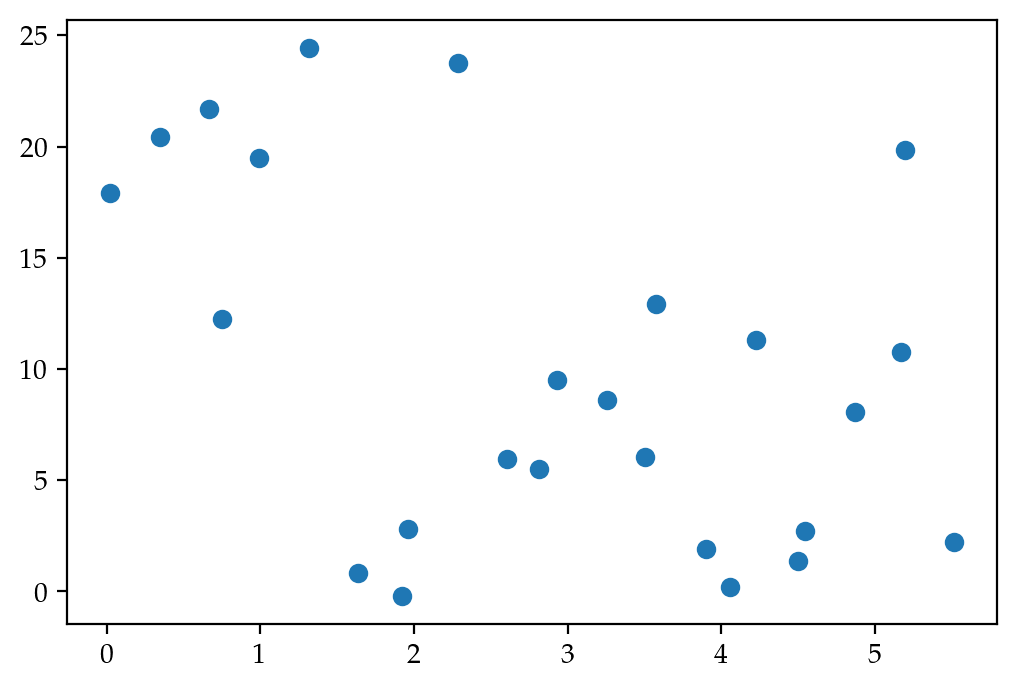

In [177]:
time_until_quench_slice = time_until_quench[(time_until_quench > 0)&(data.time > 2.2)] 

plt.figure(dpi=200)
plt.scatter(time_until_quench_slice, HI_depletion_times - time_until_quench_slice)
plt.show()

Definitely different from 0. So, using this model, strangulation alone cannot account for the loss in HI and the quenching of the halo. 

In [17]:
data = read_file('h242',35)
c_sfh, bc = cumulative_sfh('h242',35)

<Figure size 432x288 with 0 Axes>

First, we get the quenching time, defined as the point at which the halo forms 99% if its present day stellar mass. 

In [18]:
age = 13.800797497330507
tquench = age - np.max(bc[c_sfh > 0.99])
print(f'Quenching time {tquench:.2f} Gyr')

Quenching time 12.20 Gyr


Now, we compute the atomic hydrogen depletion times at various timesteps through the star formation history. That is, at every snapshot post-reionization but prior to the quenching time, we compute the instantanous atomic hydrogen gas depletion time $M_{\mathrm{HI}}/\mathrm{SFR}$. 

In [19]:
time_until_quench = np.array(tquench - data.time) # this array is exactly what it says it is -- the time until the quenching epoch, for each timestep
sfr = np.array(data.sfr[(time_until_quench > 0)&(data.time > 2.2)], dtype=float) # the star formation rate at each snapshot post-reionization and prior to quenching
mHI = np.array(data.mHI[(time_until_quench > 0)&(data.time > 2.2)], dtype=float)

HI_depletion_times = mHI / sfr / 1e9 # divide by 1e9 since we want depletion times in Gyr and SFR is given in Msol/yr

for i in range(len(HI_depletion_times)):
    print(mHI[i],'\t',sfr[i],'\t',HI_depletion_times[i])


3213092.724791986 	 6.728019205474919e-05 	 47.7568899056848
2876800.085310373 	 6.540721117436572e-05 	 43.98291921729027
3005935.7315280894 	 6.638956019845265e-05 	 45.277235193947696
2424290.6671613567 	 0.00021413406158717874 	 11.32136872196941
2964286.6288876194 	 0.0001315510135745885 	 22.53336214096815
2933324.0153867854 	 0.0002718665452629713 	 10.789573290635808
5318067.825191913 	 0.00020704702253788887 	 25.685314186146897
3238092.5065520736 	 0.00027593820378358553 	 11.734846650997497
3673359.332634349 	 0.00021041961775348752 	 17.457304465488537
3548363.7895390857 	 0.00015184304081536409 	 23.36862967499297
2170483.180875081 	 6.811583160458494e-05 	 31.864591971435082
2094980.765532558 	 7.231472756505153e-05 	 28.970319547259507
1885894.0354776653 	 0.00013355504858626743 	 14.120724416190876
1166801.8794714967 	 0.00013442794405291644 	 8.679756933663992
2734294.467477947 	 0.00015124988638037145 	 18.077993530531284
1580995.698751678 	 0.0001449776850490474 	 10

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


Now, consider the following. If quenching was driven purely by strangulation, we would expect that at each timestep, the time until quenching would be roughly equivalent to the instantanous HI depletion timescale. So, we would expect that the mean difference between the HI depletion timescale and the time until quenching would be not different from 0. So, let's test that!

In [20]:
import scipy
time_until_quench_slice = time_until_quench[(time_until_quench > 0)&(data.time > 2.2)] # get a specific slice of the time until quench, post-reionization and pre-quench
median = np.median(HI_depletion_times - time_until_quench_slice)
iqr = scipy.stats.iqr(HI_depletion_times - time_until_quench_slice)
print(f'HI depletion - time until quench, {median:.2f} ± {iqr/2:.2f}')

HI depletion - time until quench, 10.66 ± 9.54


In [37]:
print(data.keys())

Index(['HIratio', 'Pram', 'Prest', 'Rvir', 'SNHfrac', 'env_rho', 'fHI',
       'gasfrac', 'gtemp', 'h1dist', 'haloid', 'inflow_23', 'inflow_91',
       'inflow_temp_23', 'inflow_temp_91', 'mHI', 'mass', 'mgas', 'mstar',
       'outflow_23', 'outflow_91', 'outflow_temp_23', 'outflow_temp_91',
       'ratio', 'sfr', 'time', 'v_env', 'v_halo', 'v_halo1', 'z0haloid'],
      dtype='object')


Halo 4.0
Gathering data...


<Figure size 432x288 with 0 Axes>

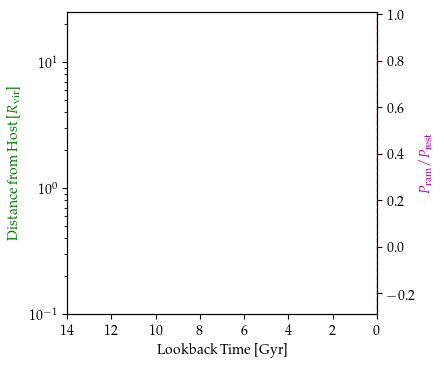

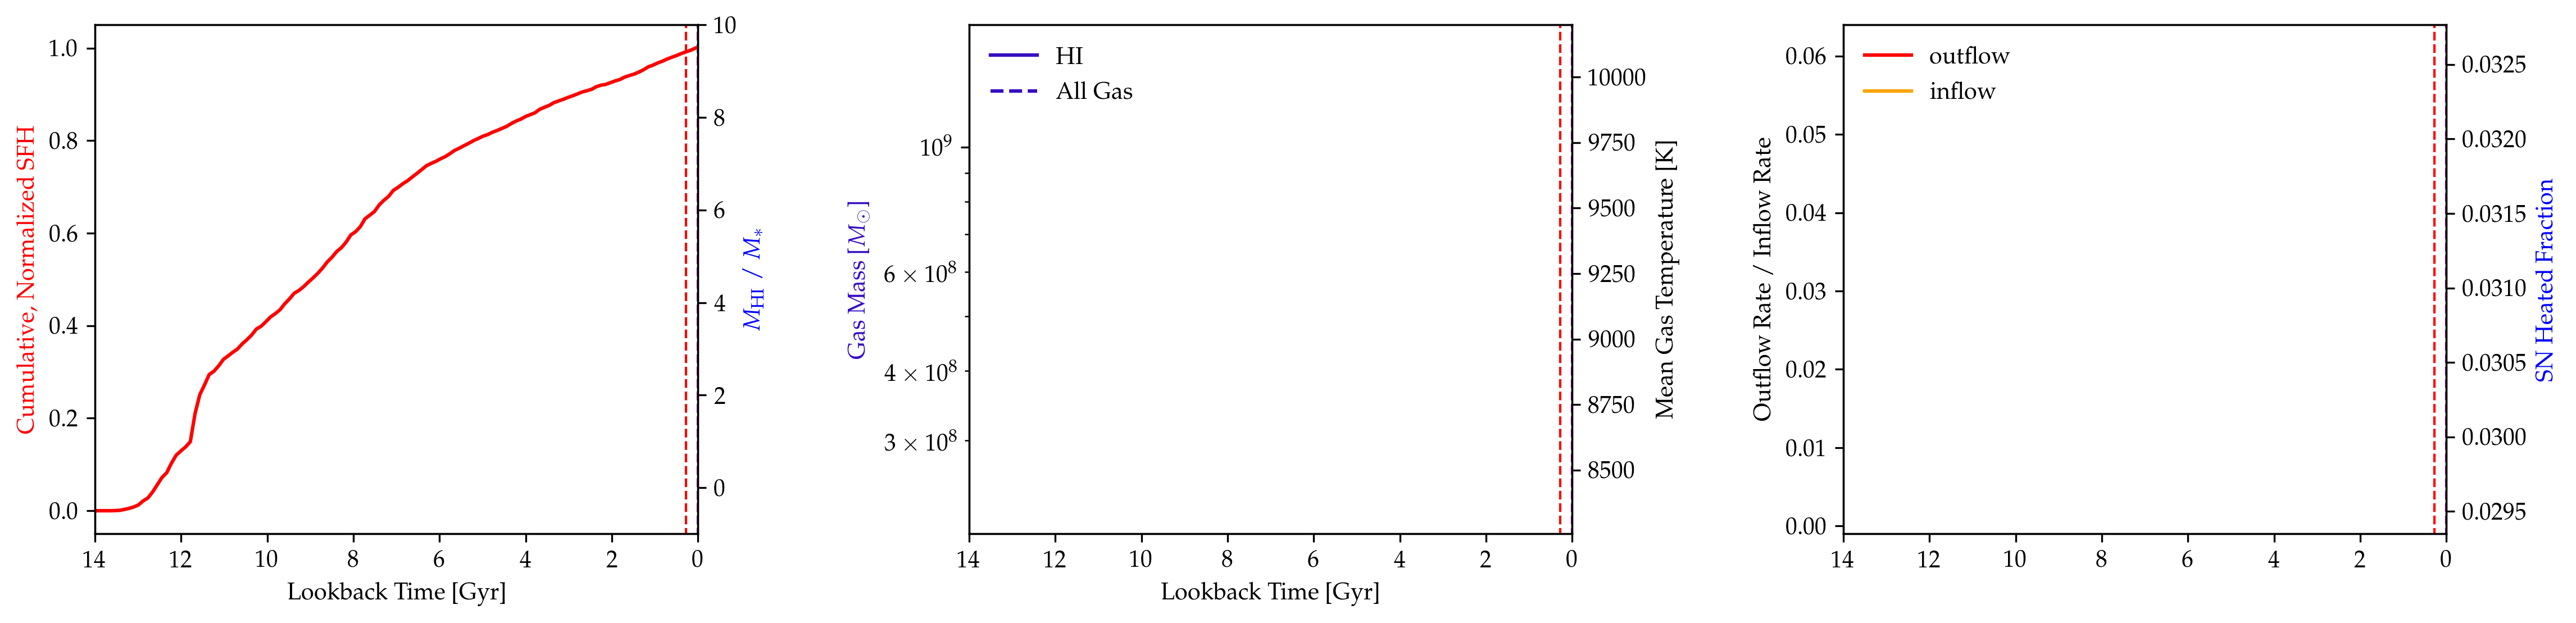

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


HI depletion - time until quench, nan ± nan


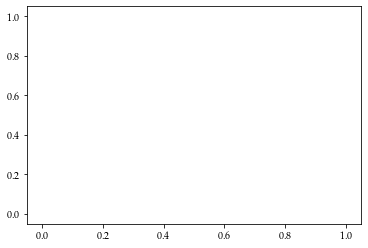

Halo 10.0
Gathering data...


<Figure size 432x288 with 0 Axes>

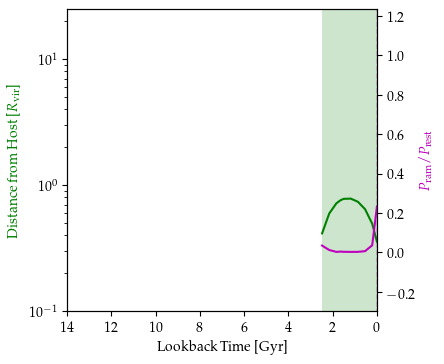

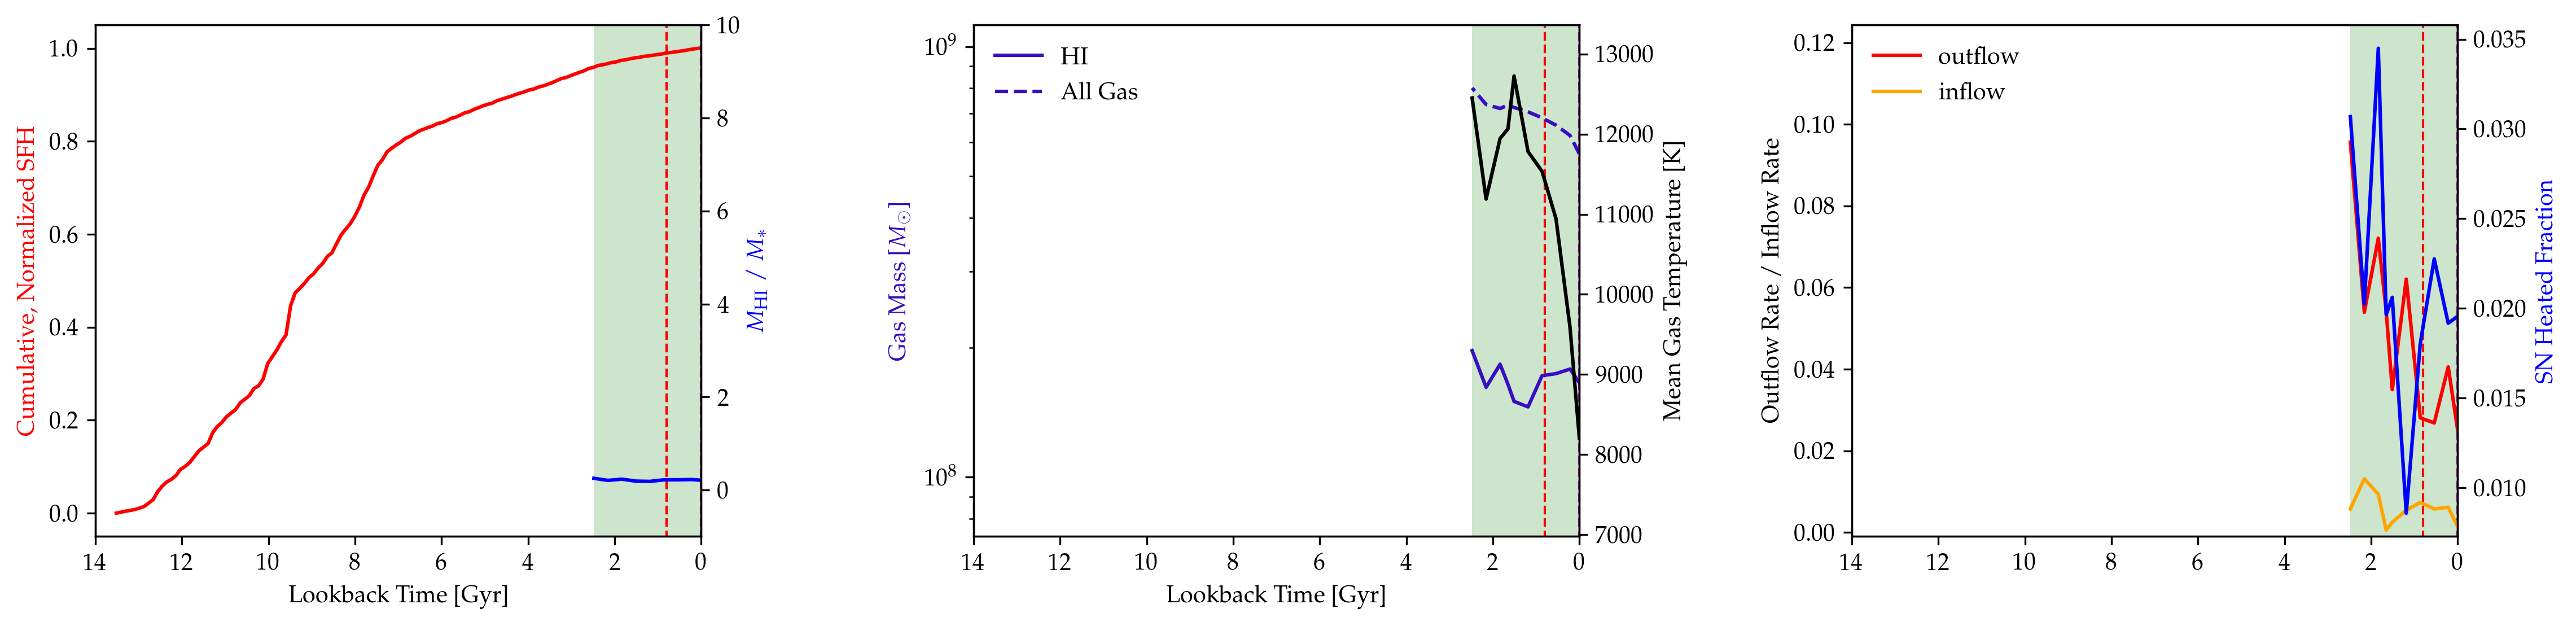

HI depletion - time until quench, nan ± nan


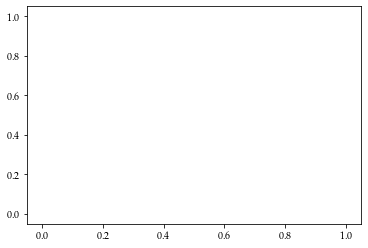

Halo 21.0
Gathering data...


<Figure size 432x288 with 0 Axes>

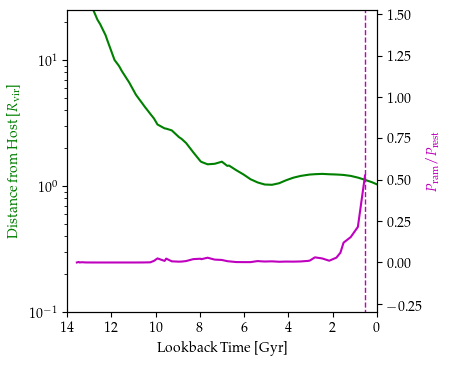

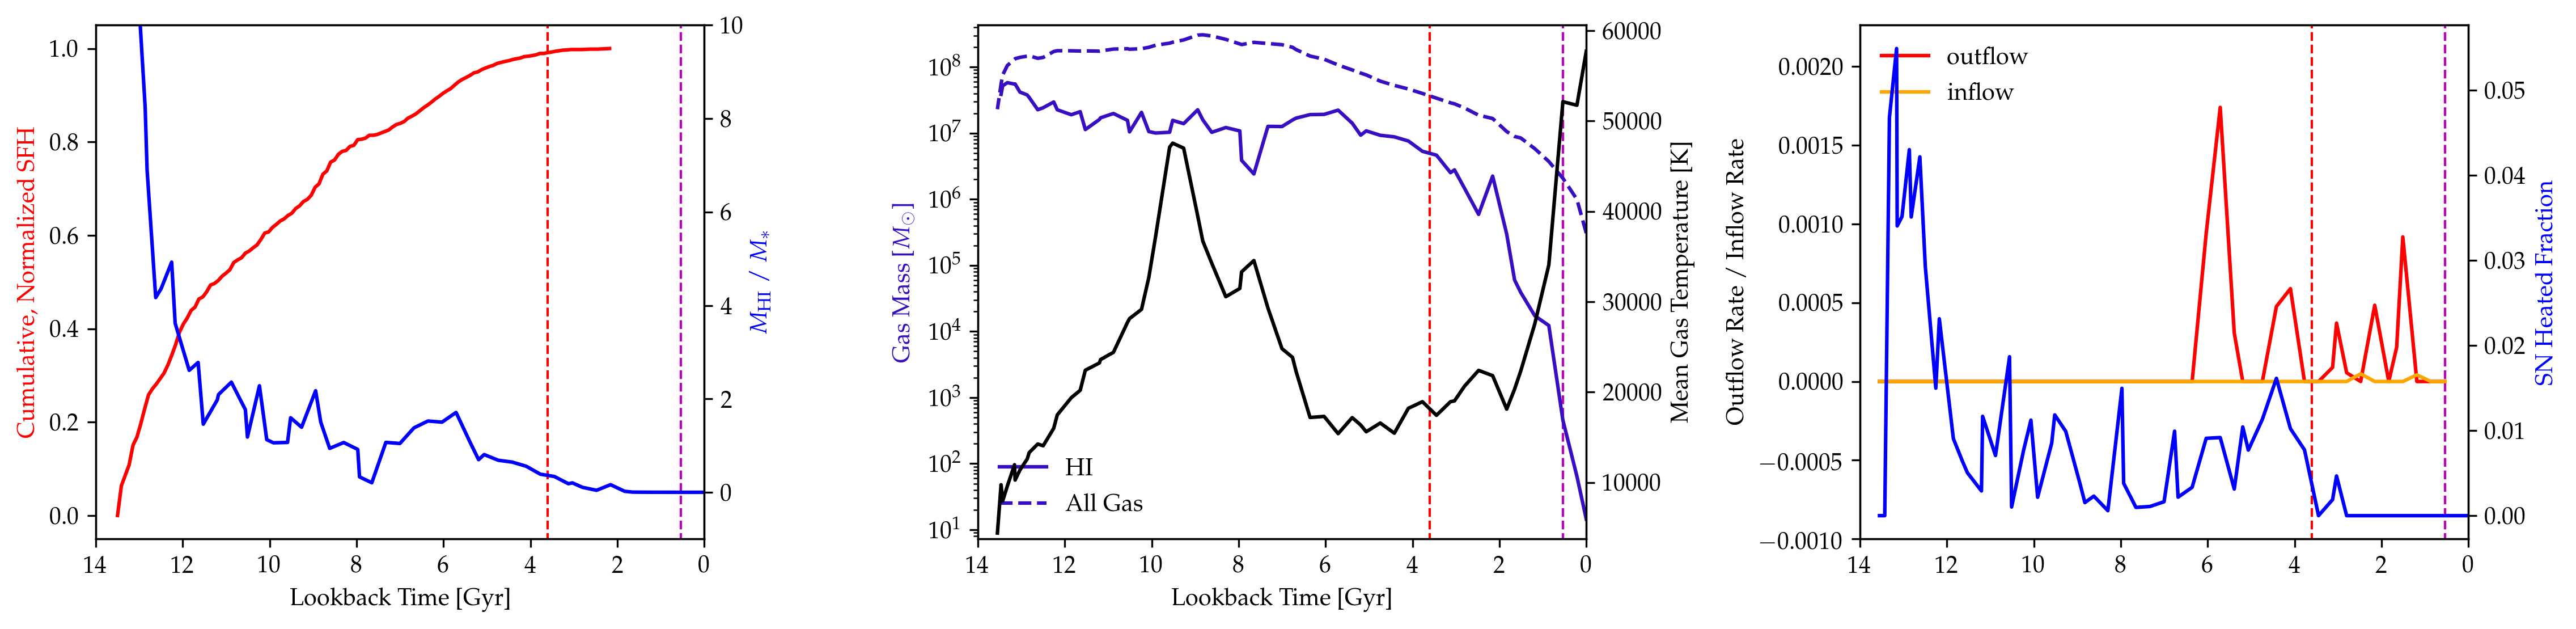

HI depletion - time until quench, 8.61 ± 7.59


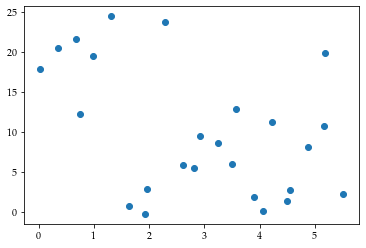

Halo 27.0
Gathering data...


<Figure size 432x288 with 0 Axes>

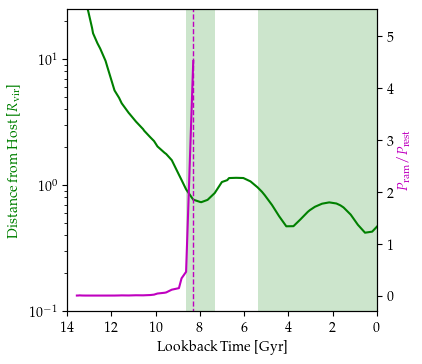

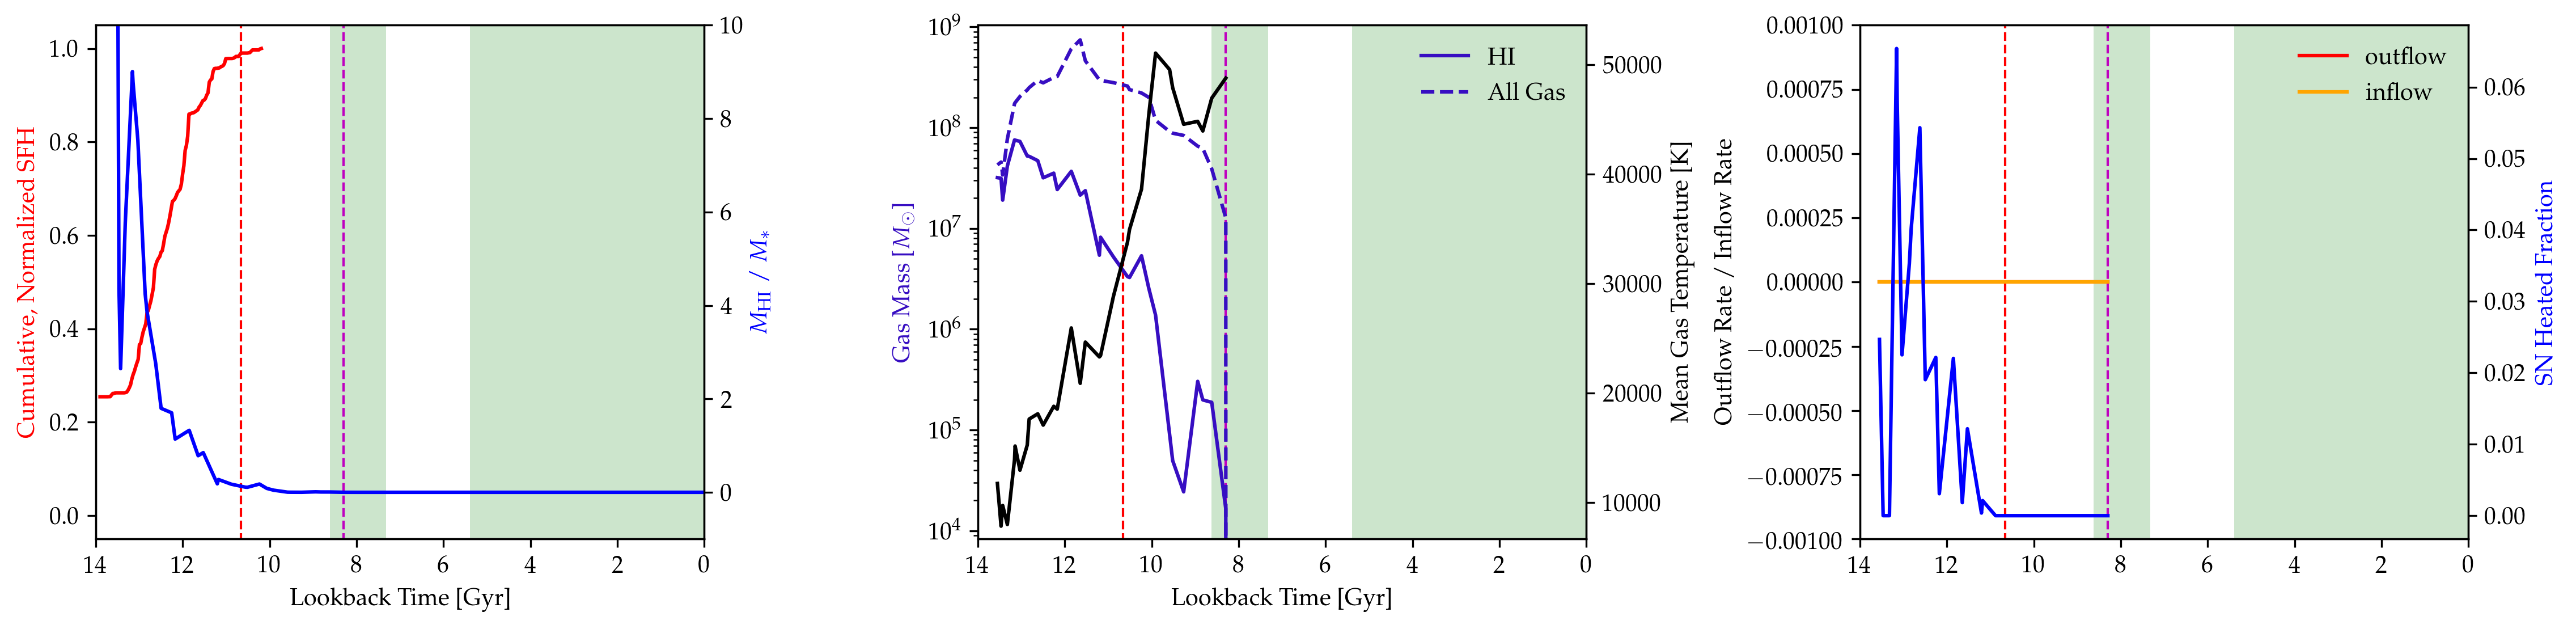

HI depletion - time until quench, 3.42 ± 0.00


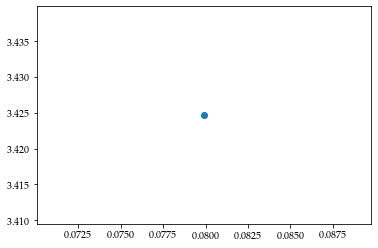

Halo 31.0
Gathering data...


<Figure size 432x288 with 0 Axes>

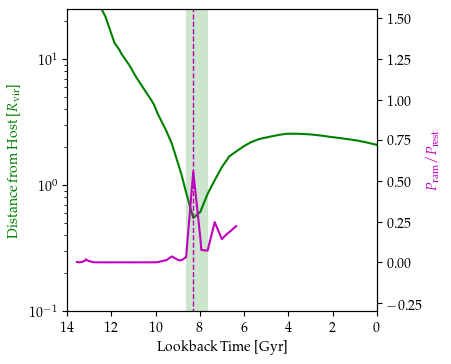

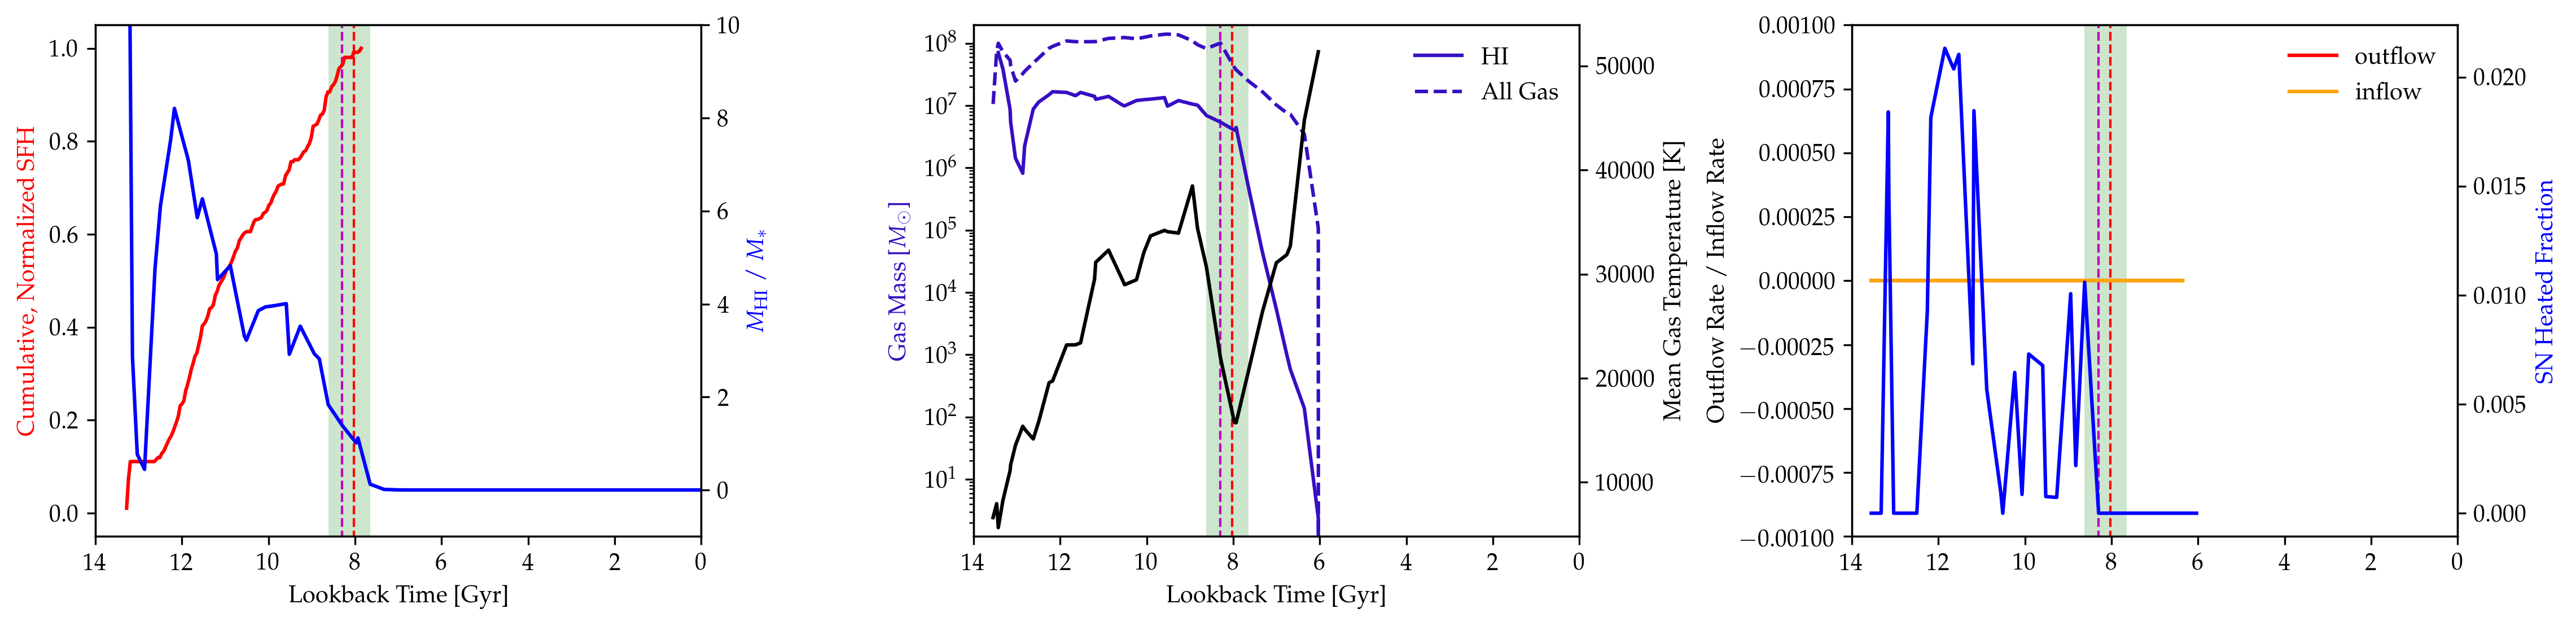

HI depletion - time until quench, 22.37 ± 6.45


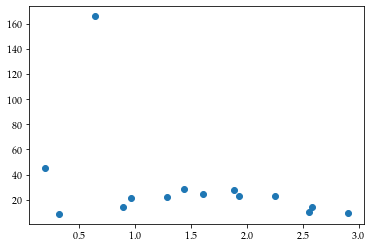

Halo 35.0
Gathering data...


<Figure size 432x288 with 0 Axes>

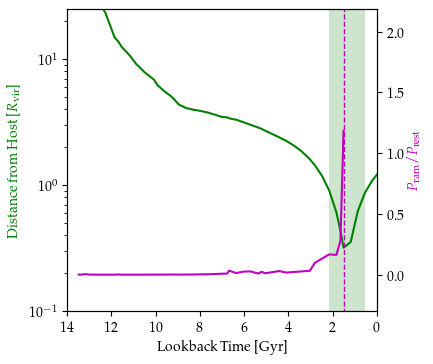

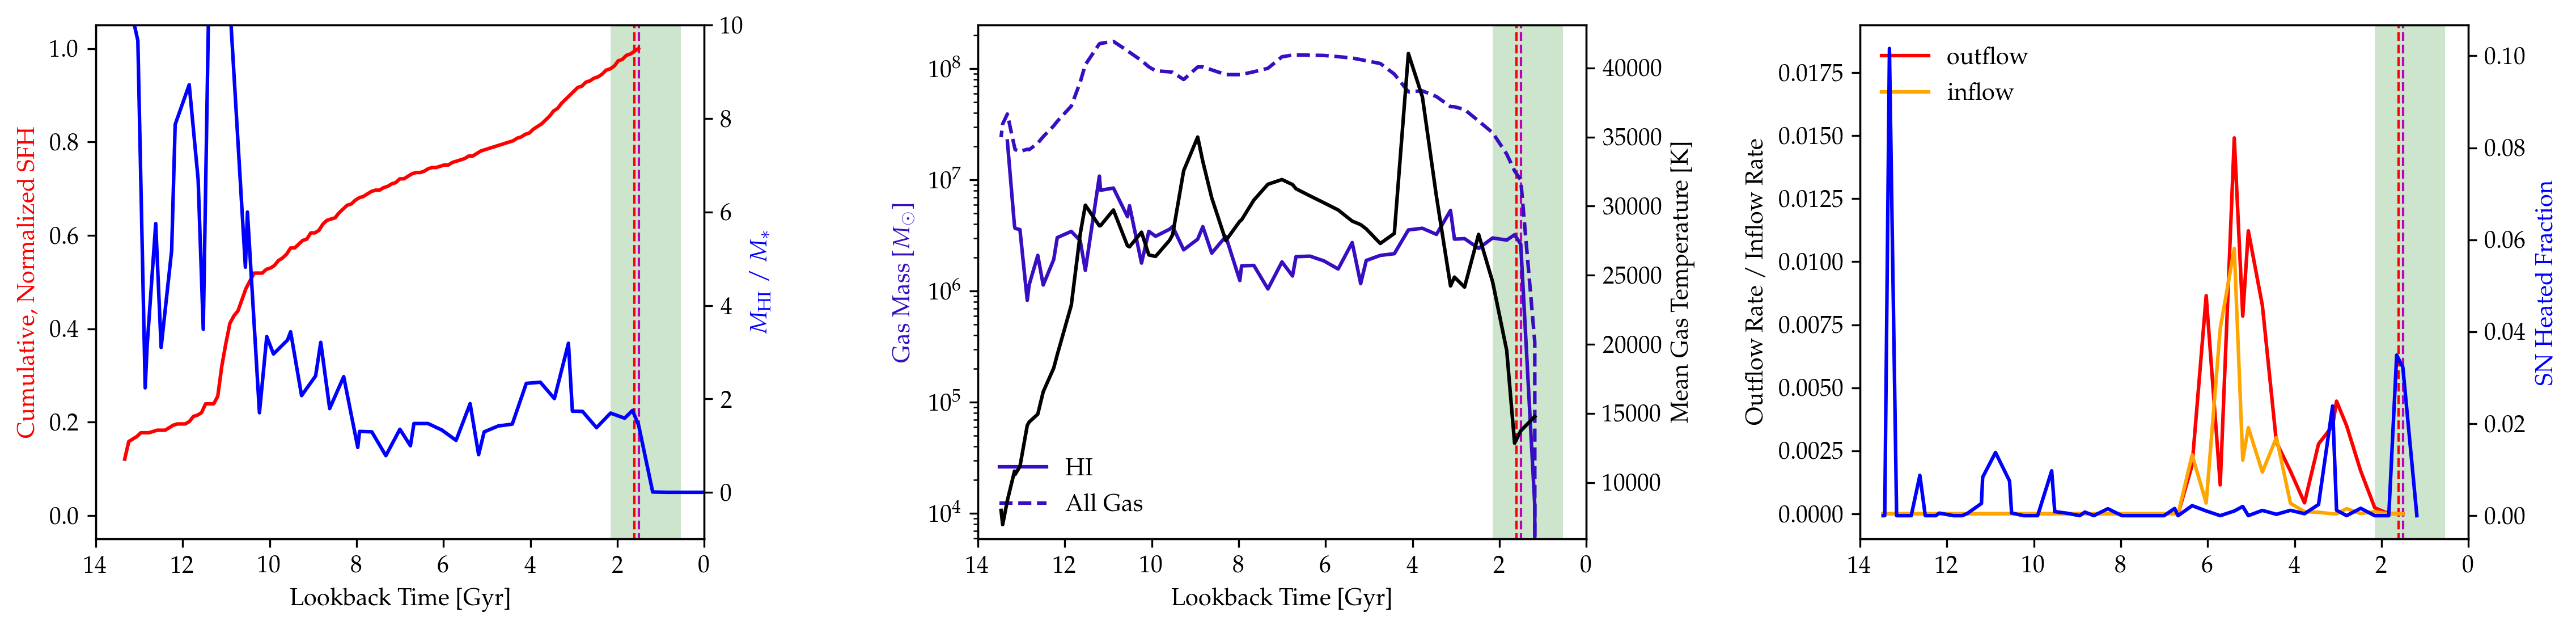

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


HI depletion - time until quench, 11.29 ± 8.47


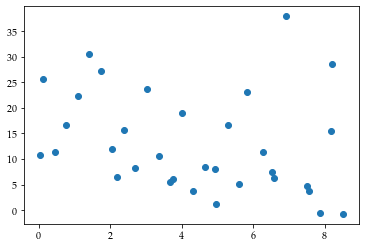

Halo 37.0
Gathering data...


<Figure size 432x288 with 0 Axes>

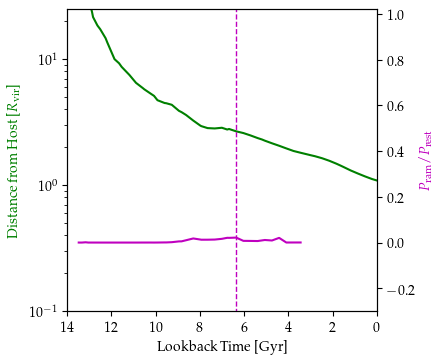

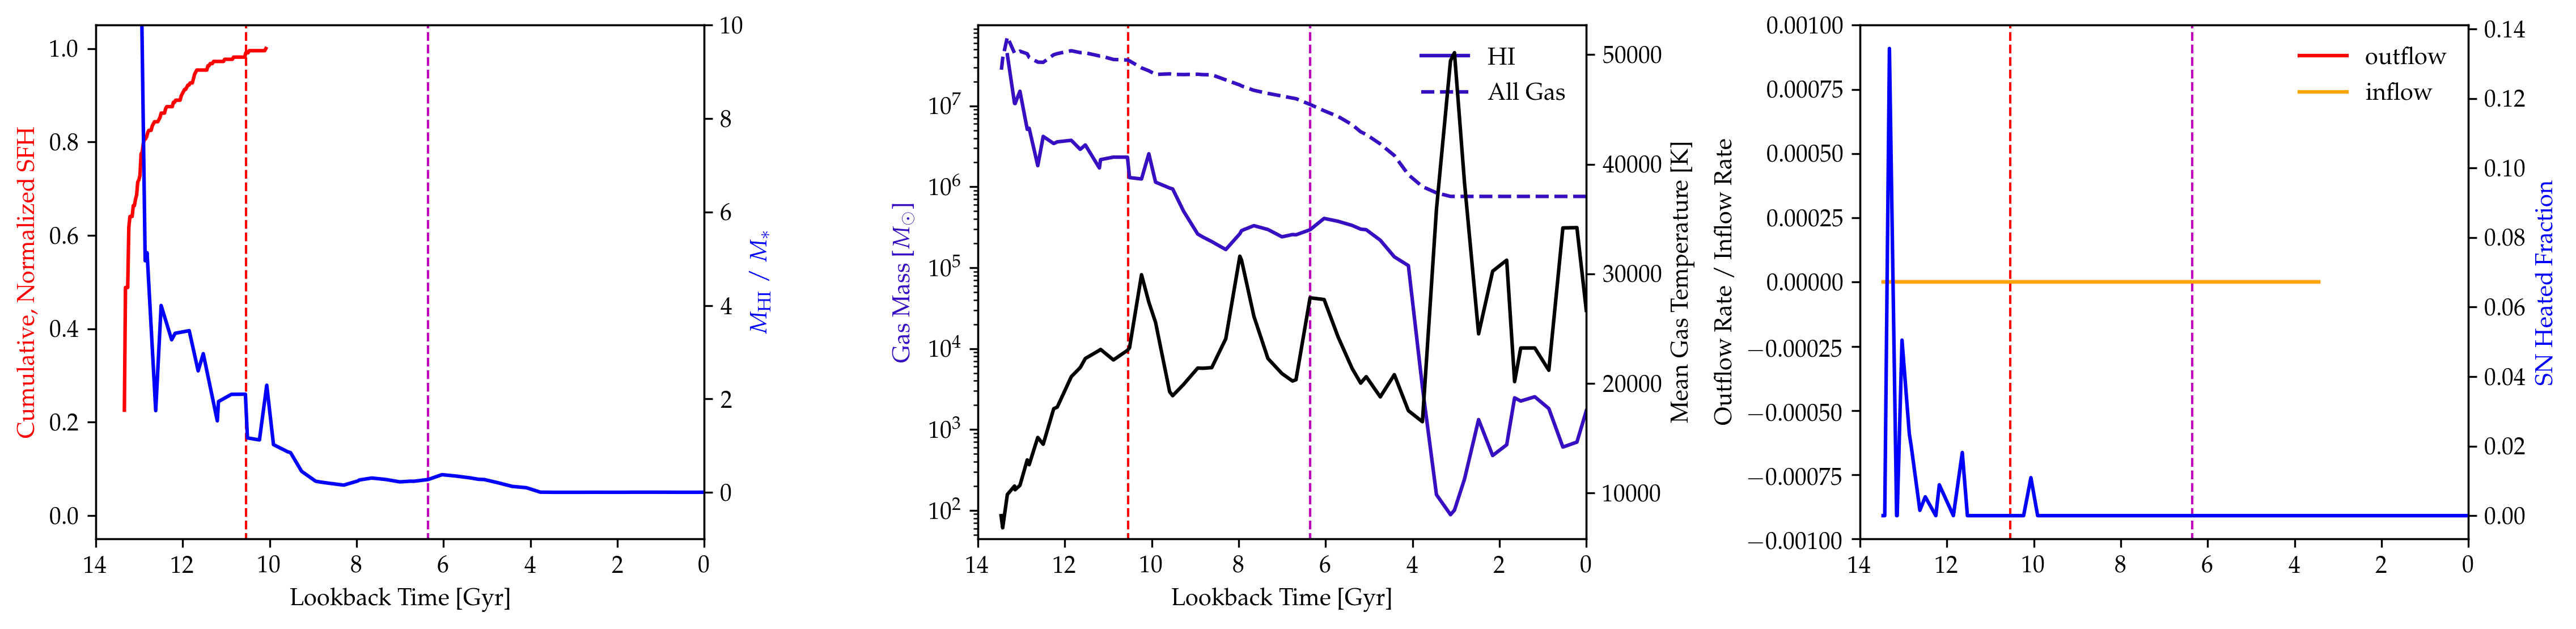

HI depletion - time until quench, nan ± nan


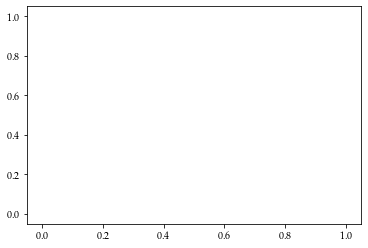

Halo 45.0
Gathering data...


<Figure size 432x288 with 0 Axes>

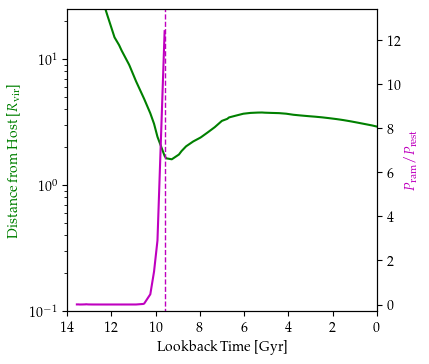

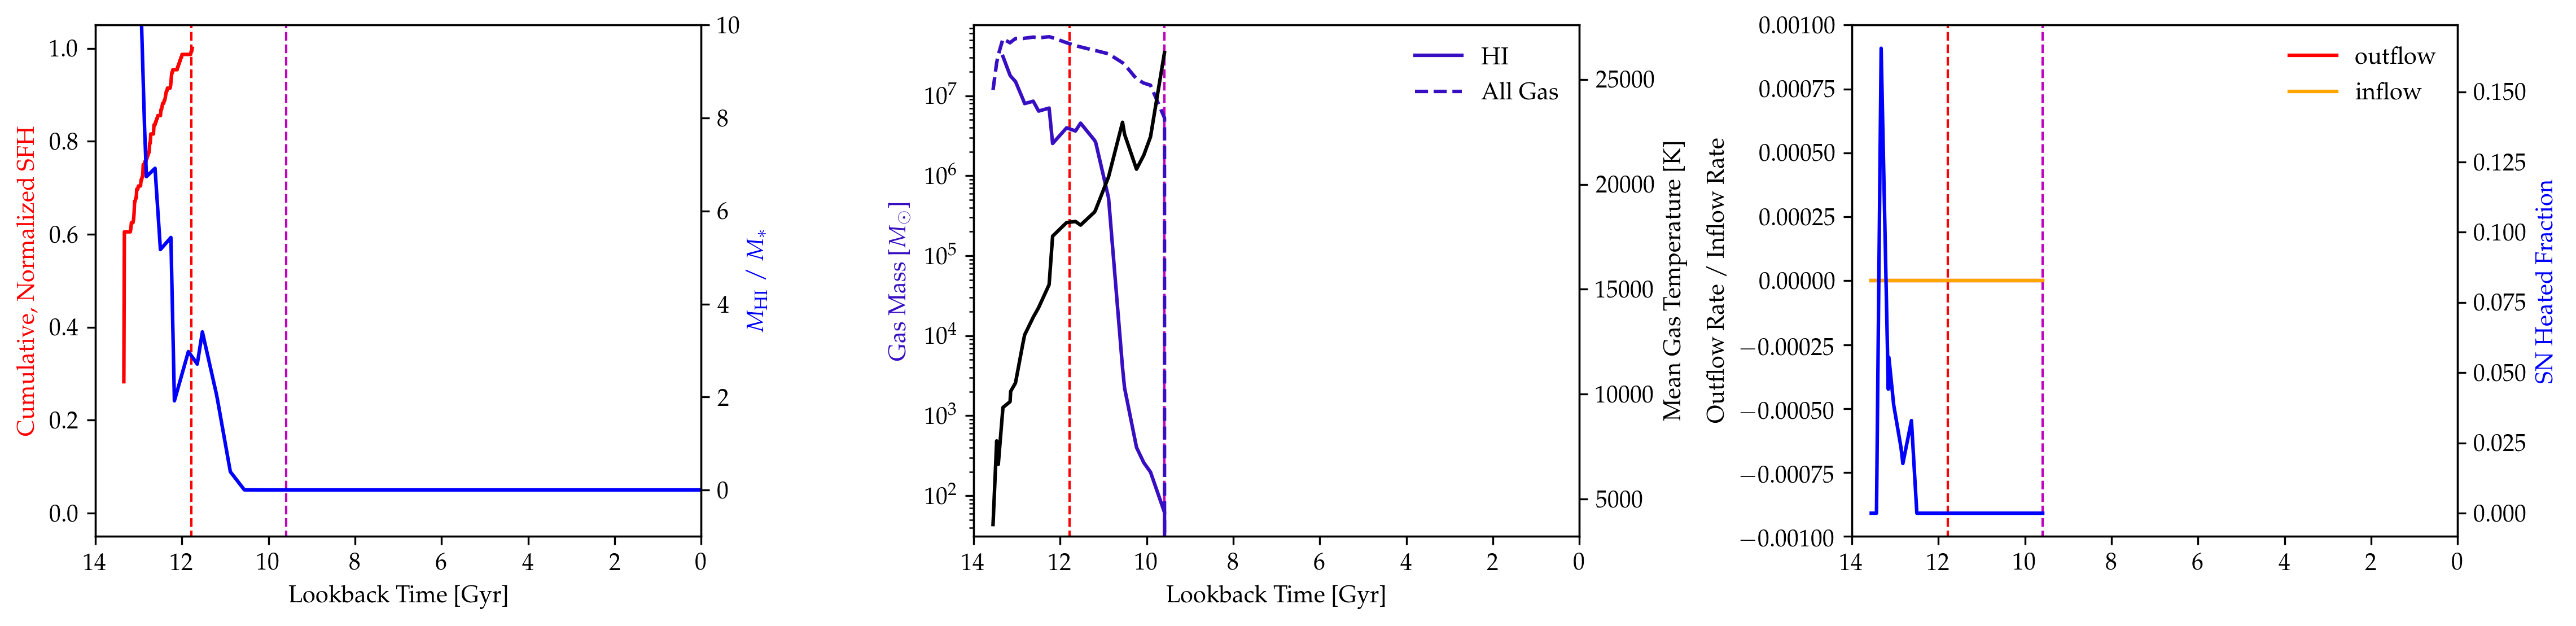

HI depletion - time until quench, nan ± nan


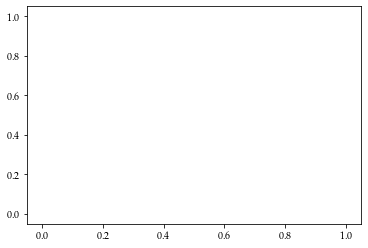

Halo 47.0
Gathering data...


<Figure size 432x288 with 0 Axes>

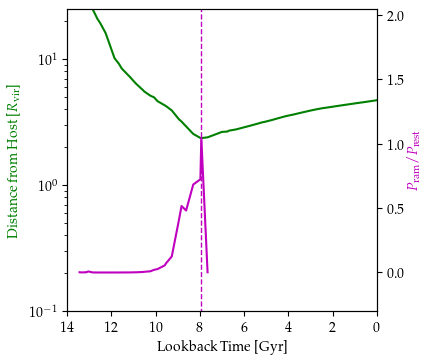

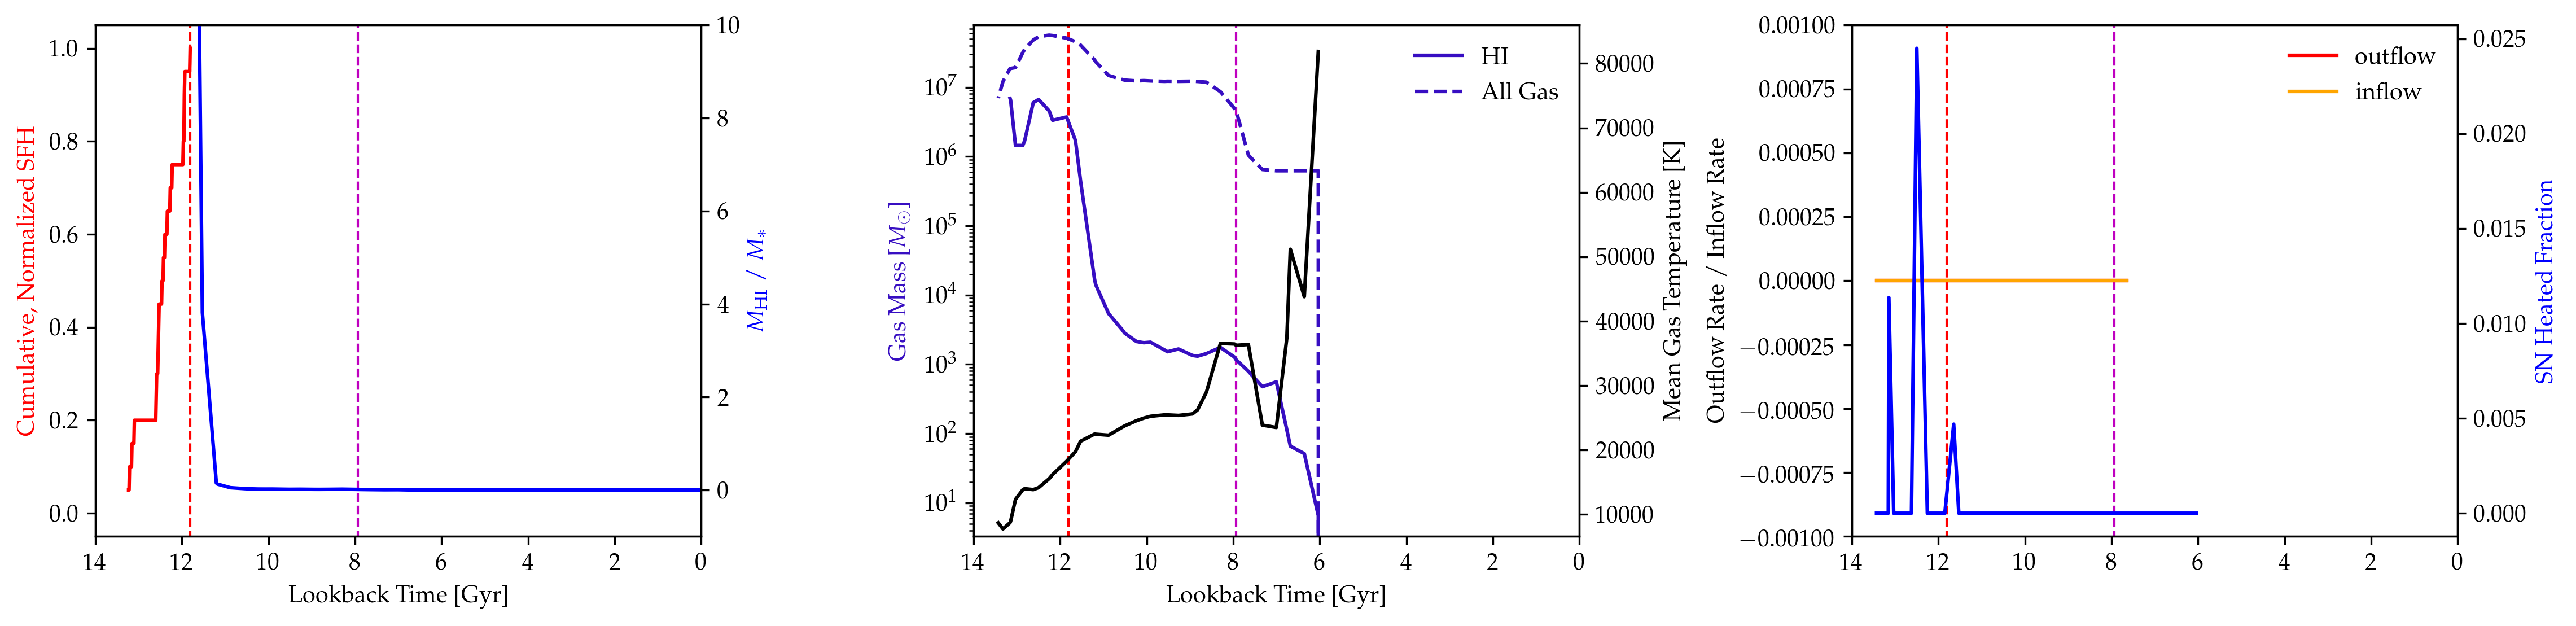

HI depletion - time until quench, nan ± nan


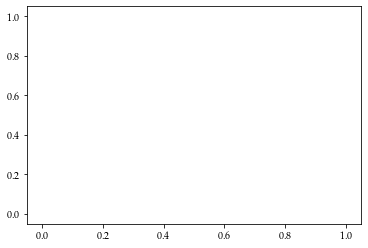

Halo 48.0
Gathering data...


<Figure size 432x288 with 0 Axes>

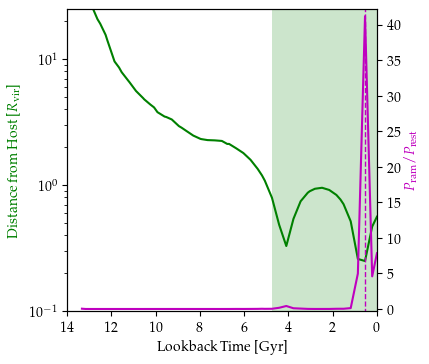

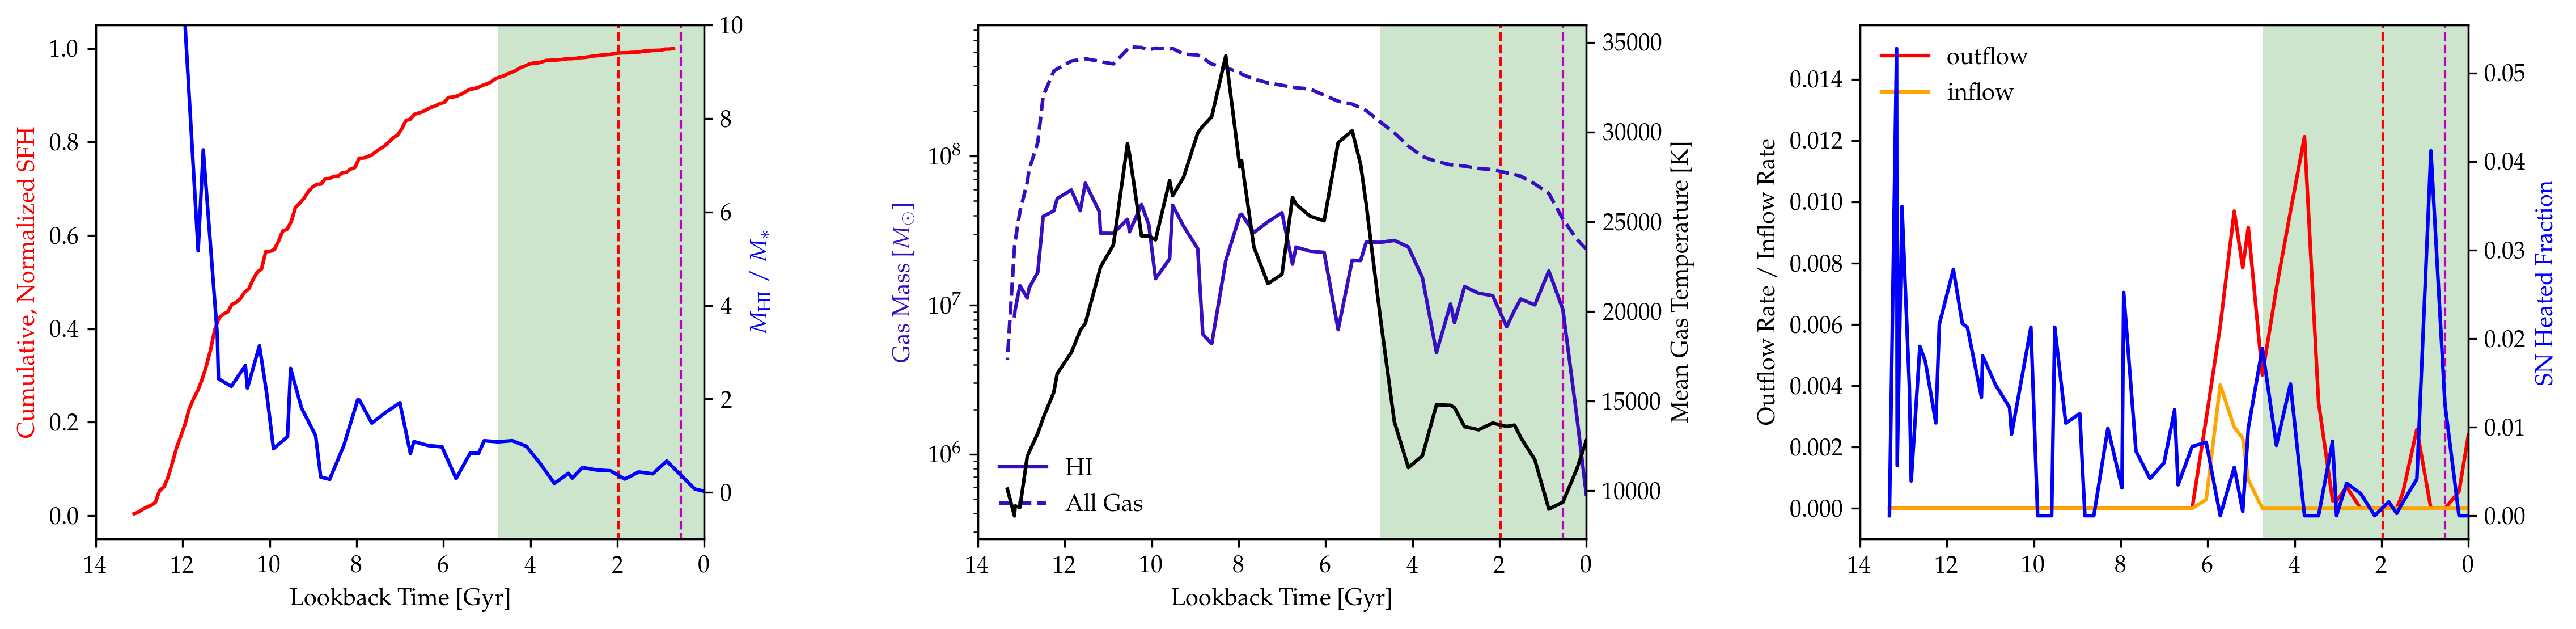

HI depletion - time until quench, 6.25 ± 8.35


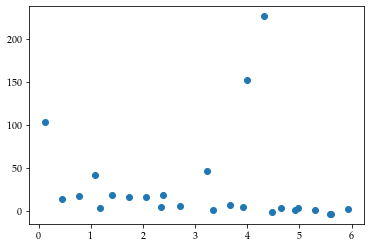

Halo 49.0


/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/plot/stars.py:632: RuntimeWarning: divide by zero encountered in true_divide
  binnorm = 1e-9 * bins / (trange[1] - trange[0])
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


Halo never quenched, skipping
Halo 67.0
Gathering data...


<Figure size 432x288 with 0 Axes>

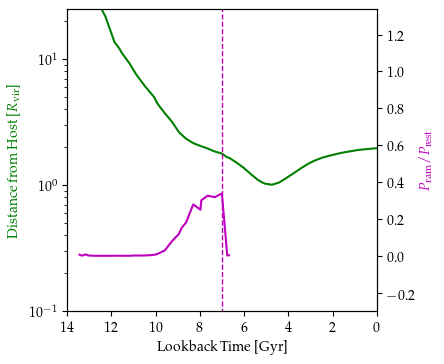

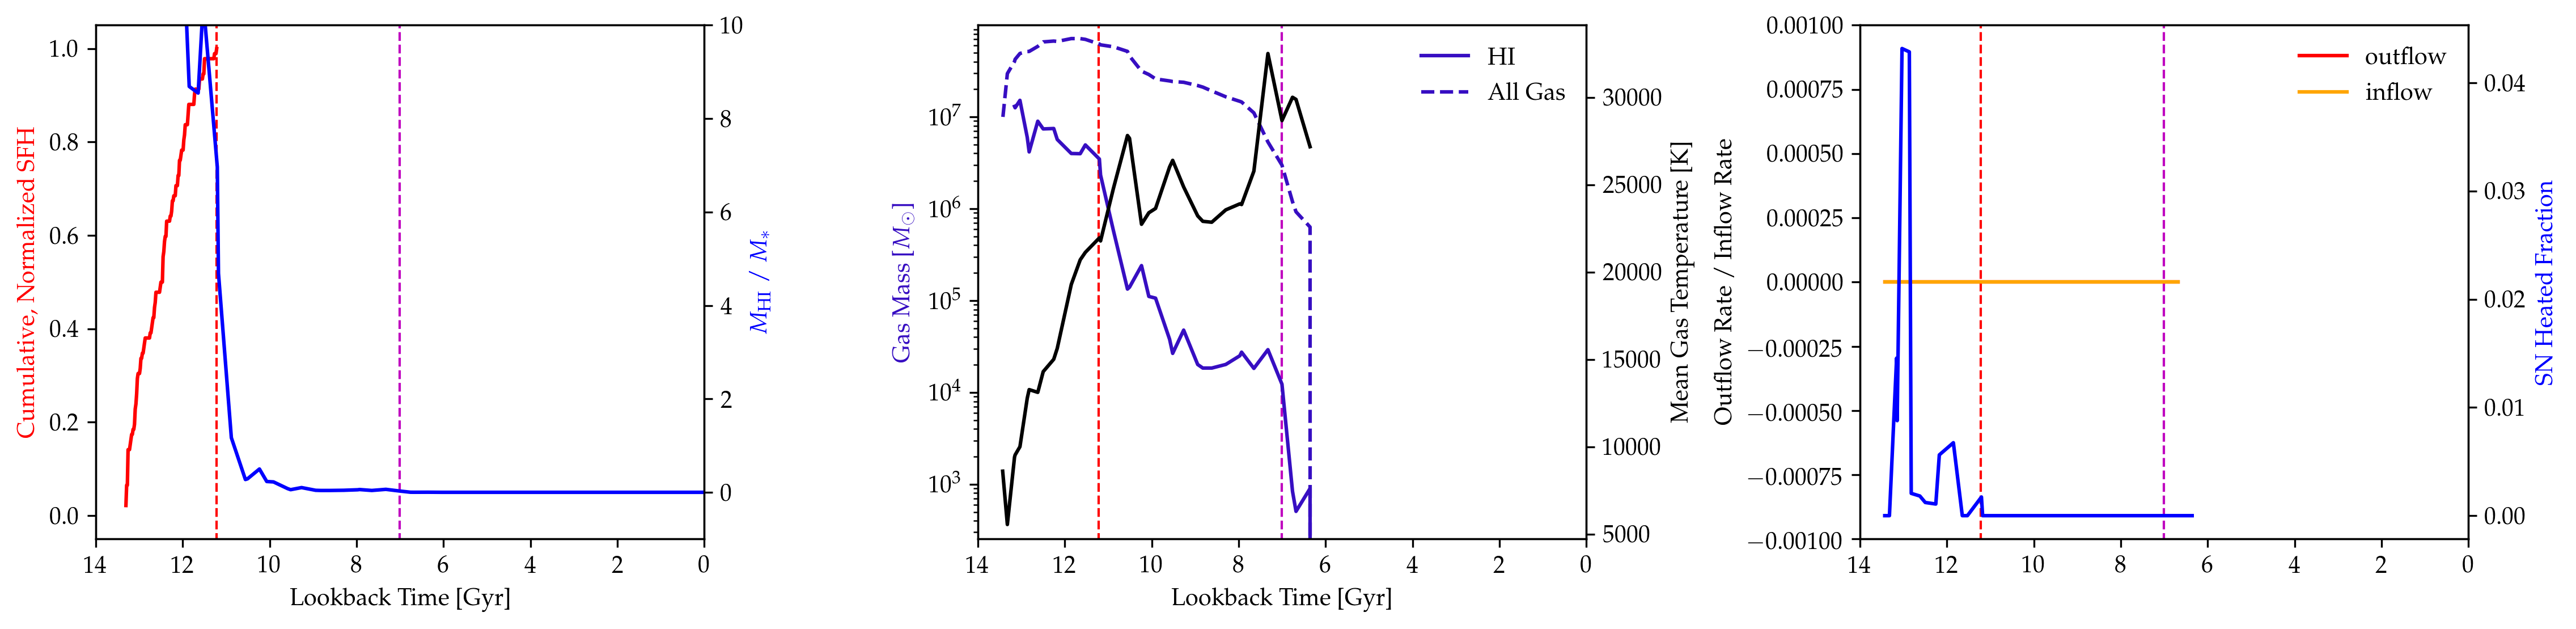

HI depletion - time until quench, nan ± nan


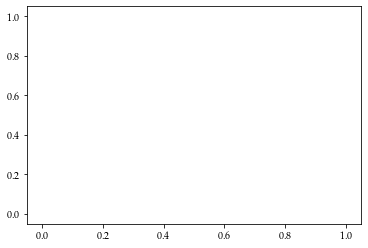

Halo 71.0
Gathering data...


<Figure size 432x288 with 0 Axes>

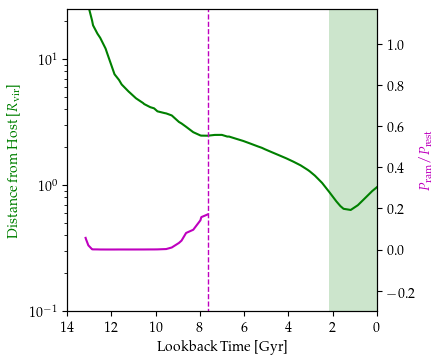

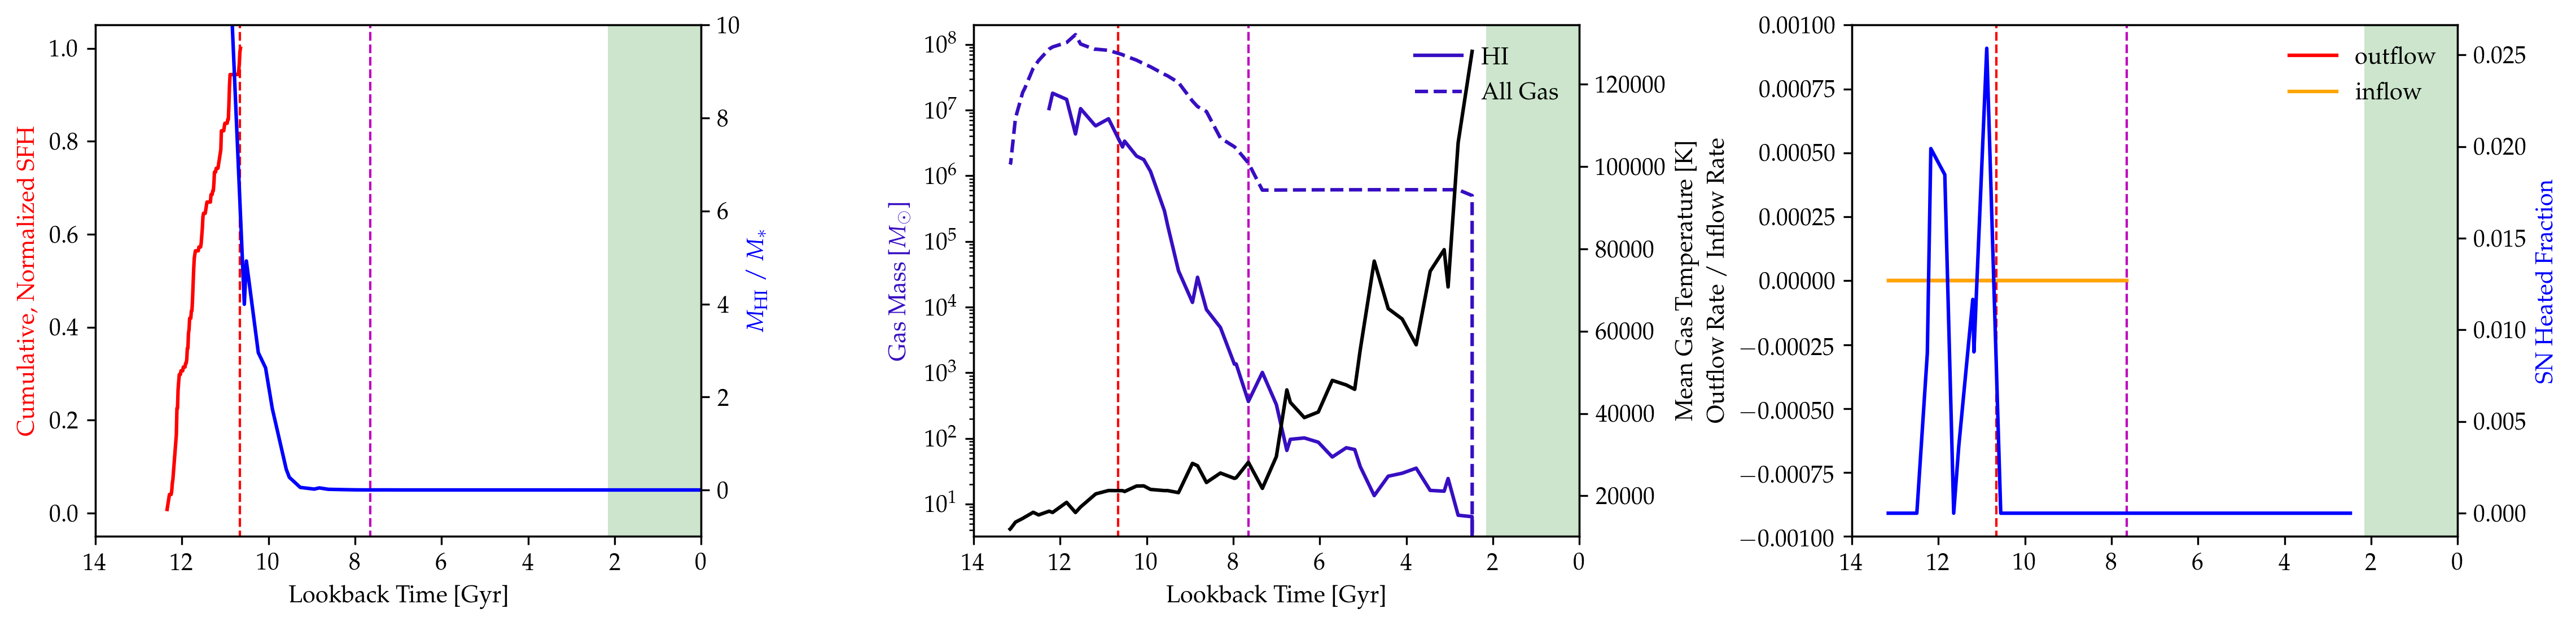

HI depletion - time until quench, 14.30 ± 4.08


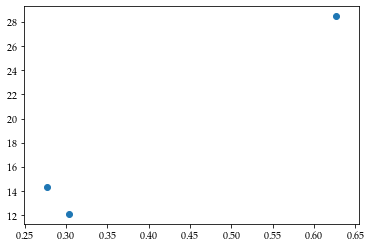

Halo 81.0
Gathering data...


<Figure size 432x288 with 0 Axes>

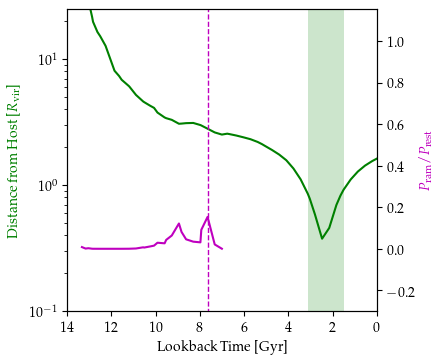

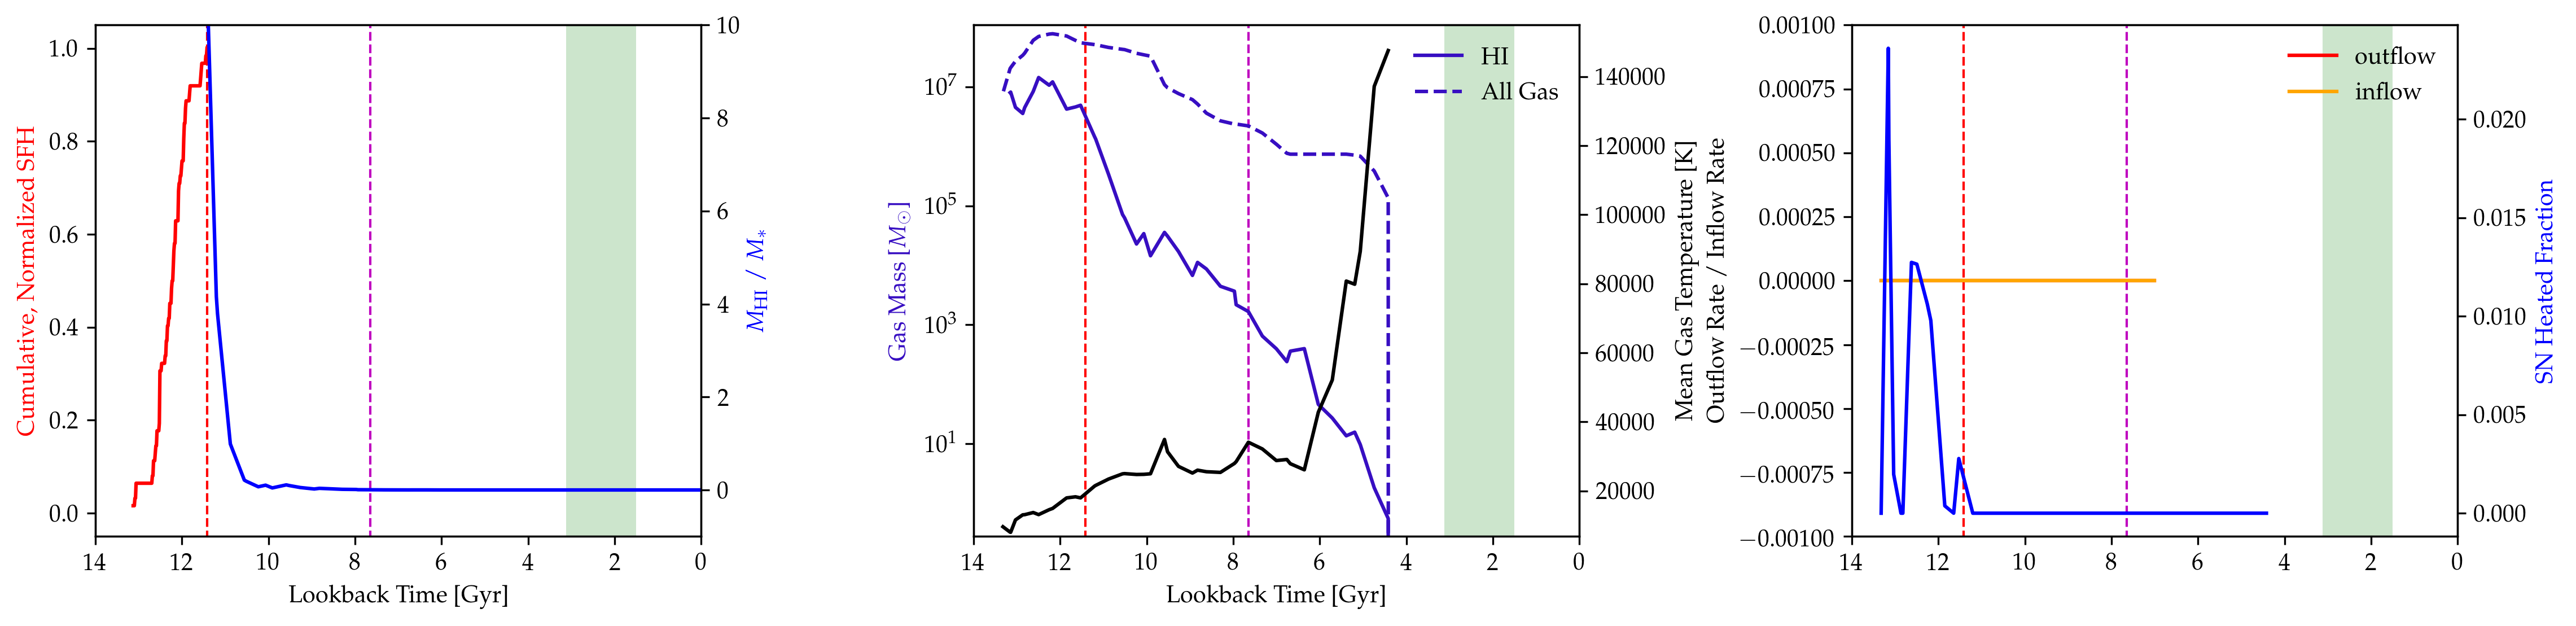

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


HI depletion - time until quench, nan ± nan


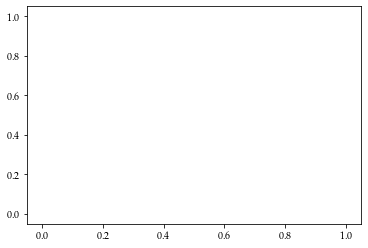

Halo 102.0
Gathering data...


ValueError: zero-size array to reduction operation minimum which has no identity

<Figure size 432x288 with 0 Axes>

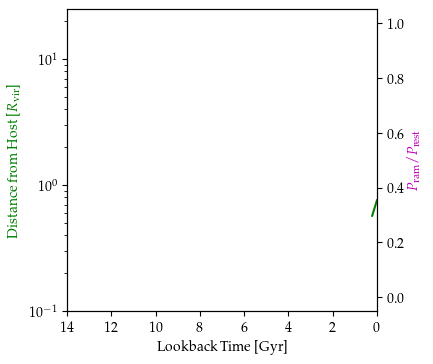

In [21]:
medians, iqrs, sims, newids, mstars = [],[],[],[],[]

name = 'h242'
data = read_file(name,'all')
ids = np.unique(np.array(data.z0haloid))
for i in ids:
    print(f'Halo {i}')
    data = read_file(name,i)
    c_sfh, bc = cumulative_sfh(name,i)
    age = 13.800797497330507
    try:
        tquench = age - np.max(bc[c_sfh > 0.9])
    except:
        print('Halo never quenched, skipping')
        continue
        
    CaseStudyPlots(name,i)
        
    # print(f'Quenching time {tquench:.2f} Gyr')
    time_until_quench = np.array(tquench - data.time) # this array is exactly what it says it is -- the time until the quenching epoch, for each timestep
    sfr = np.array(data.sfr[(time_until_quench > 0)&(data.time > 2.2)], dtype=float) # the star formation rate at each snapshot post-reionization and prior to quenching
    mHI = np.array(data.mHI[(time_until_quench > 0)&(data.time > 2.2)], dtype=float)

    HI_depletion_times = mHI / sfr / 1e9 # divide by 1e9 since we want depletion times in Gyr and SFR is given in Msol/yr
    time_until_quench_slice = time_until_quench[(time_until_quench > 0)&(data.time > 2.2)] # get a specific slice of the time until quench, post-reionization and pre-quench
    
    median = np.median(HI_depletion_times - time_until_quench_slice)
    iqr = scipy.stats.iqr(HI_depletion_times - time_until_quench_slice)
    print(f'HI depletion - time until quench, {median:.2f} ± {iqr/2:.2f}')
    plt.scatter(time_until_quench_slice, HI_depletion_times - time_until_quench_slice)
    plt.show()
    
    medians.append(median)
    iqrs.append(iqr)
    sims.append(name)
    newids.append(i)
    mstars.append(data.mstar[data.time > 13.6].tolist()[0])

Gathering data...


<Figure size 432x288 with 0 Axes>

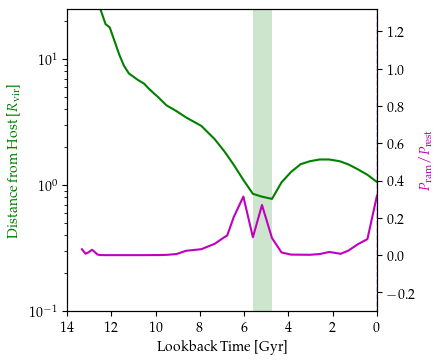

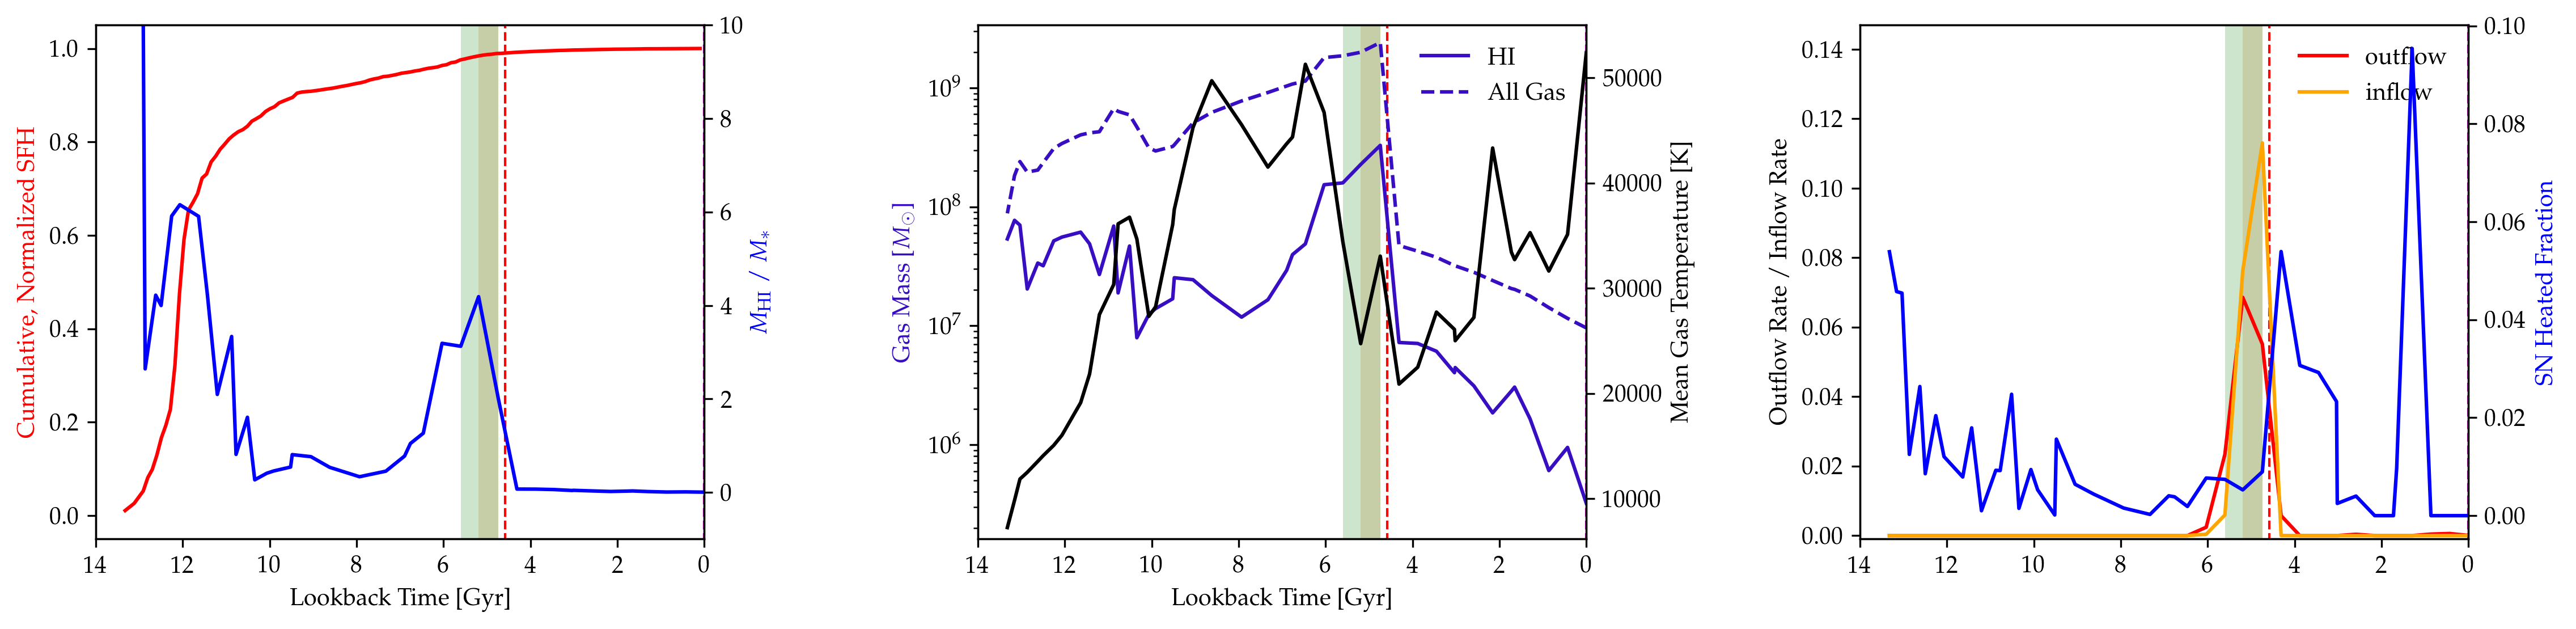

In [35]:
CaseStudyPlots('h148',12)

In [52]:
data = read_file('h148',12)
t_depl = np.array(data.mHI[data.sfr != 0.],dtype=float) / np.array(data.sfr[data.sfr != 0.],dtype=float)
time = np.array(data.time[data.sfr != 0.],dtype=float)
for t, t_d in zip(time, t_depl):
    print(age-t,'\t',t_d/1e9)

2.4507507134785556e-10 	 2.351565491599948
0.8619607610705877 	 4.550025701040876
1.2929411414833467 	 5.952687187968221
1.649846769012683 	 14.749209777310364
1.7239215218961164 	 42.980593362019164
2.154901902310389 	 13.833625933754597
2.5858822827275567 	 11.685474574431273
3.0168626631419055 	 22.013174465355817
3.033697834254424 	 14.768932636087047
3.447843043558656 	 14.461576141714431
3.8788234239714097 	 8.55499260103313
4.309803804384165 	 7.641105323448296
4.740784184796915 	 19.9139341192056
5.191966770541525 	 21.226605403847707
5.602744945621538 	 17.83783239036987
6.033725326034679 	 8.045422357838271
6.464705706447678 	 14.840918178572045
6.761004717981546 	 11.297902806894518
6.895686086860574 	 9.721598616918433
7.326666467273417 	 5.075931180434568
7.932732627228911 	 2.253673358182635
8.619607608512025 	 4.615001783738413
9.05058798892963 	 9.99918413924432
9.481568369344389 	 7.2908968363460716
9.518605745786113 	 10.450882827523738
9.912548749757145 	 7.042822488

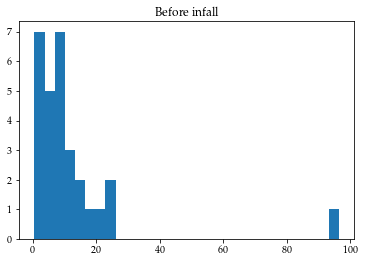

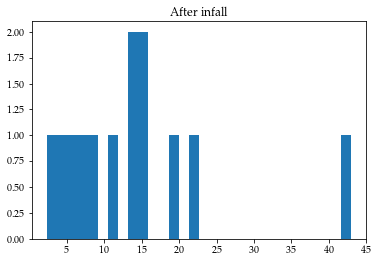

In [53]:
plt.hist(np.array(t_depl,dtype=float)[age-time > 5]/1e9, bins=30)
plt.title('Before infall')
plt.show()

plt.hist(np.array(t_depl,dtype=float)[age-time < 5]/1e9, bins=30)
plt.title('After infall')
plt.show()

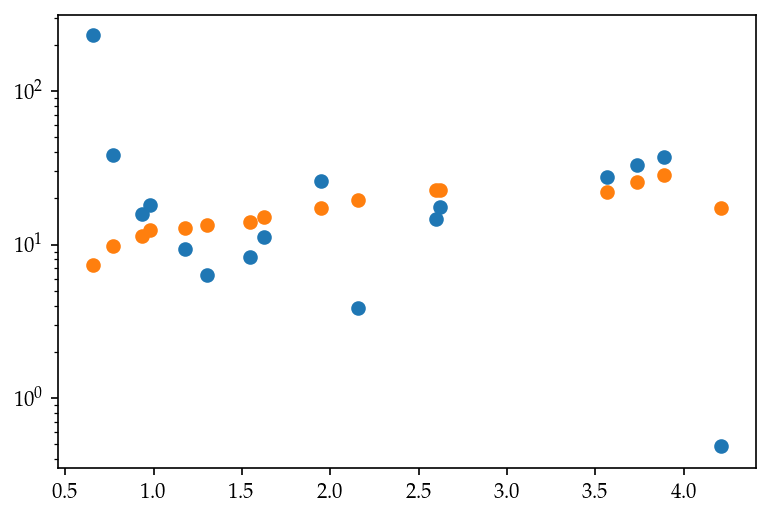

In [30]:
plt.figure(dpi=150)
plt.scatter(data.time[data.sfr != 0.], t_depl/1e9)
plt.scatter(data.time[data.sfr != 0.], data.gtemp[data.sfr != 0.]/1e3)
plt.semilogy()
plt.show()

In [31]:
s = pynbody.load('/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots/h329.cosmo50PLK.3072gst5HbwK1BH.000071')
s.physical_units()
h = s.halos()

In [32]:
H2 = np.sum(h[1].g['mass']*h[1].g['HII'])/np.sum(h[1].g['mass'])
HI = np.sum(h[1].g['mass']*h[1].g['HI'])/np.sum(h[1].g['mass'])
print(s.properties['z'], '\t', H2/HI)

15.93297883547153 	 0.02194209402176613


In [33]:
s = pynbody.load('/home/christenc/Data/Sims/h329.cosmo50PLK.3072g/h329.cosmo50PLK.3072gst5HbwK1BH/snapshots/h329.cosmo50PLK.3072gst5HbwK1BH.000275')
s.physical_units()
h = s.halos()

In [34]:
H2 = np.sum(h[1].g['mass']*h[1].g['HII'])/np.sum(h[1].g['mass'])
HI = np.sum(h[1].g['mass']*h[1].g['HI'])/np.sum(h[1].g['mass'])
print(s.properties['z'], '\t', H2/HI)

5.992850970573559 	 2.040648315711107


In [125]:
data = []
with open('/home/akinshol/Data/Timescales/QuenchingTimescales.data', 'rb') as f:
    while True:
        try:
            data.append(pickle.load(f,encoding='latin1'))
        except EOFError:
            break

data = pd.DataFrame(data)
data = data[~np.isnan(np.array(data.tinfall,dtype=float))]

tinfall = np.array(data.tinfall,dtype=float)
tinfall_lower = np.array(data.tinfall_lower, dtype=float)
tinfall_upper = np.array(data.tinfall_upper, dtype=float)
tinfall_upper_err = np.abs(tinfall_upper - tinfall)
tinfall_lower_err = np.abs(tinfall_lower - tinfall)

tquench = np.array(data.tquench,dtype=float)
tquench_lower = np.array(data.tquench_lower, dtype=float)
tquench_upper = np.array(data.tquench_upper, dtype=float)
tquench_upper_err = np.abs(tquench_upper - tquench)
tquench_lower_err = np.abs(tquench_lower - tquench)

newids = np.array(data.haloid, dtype=int)
sims = np.array(data.sim, dtype=str)
mstar = np.array(data.M_star, dtype=float)

In [126]:
depletion_times, quenching_timescales = np.array([],dtype=float),np.array([],dtype=float)

for newid, sim, ti, tq in zip(newids,sims,tinfall,tquench):
    data2 = read_file(sim,newid)
    data2 = data2[age-np.array(data2.time,dtype=float)==ti]
    
    sfr = data2.sfr.tolist()[0]
    mHI = data2.mHI.tolist()[0]
    t_depl = mHI/sfr
    
    t_q = ti-tq
    
    depletion_times = np.append(depletion_times,t_depl)
    quenching_timescales = np.append(quenching_timescales,t_q)
    

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: divide by zero encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/pynbody/array.py:346: RuntimeWarning: invalid value encountered in true_divide
  return np.ndarray.__truediv__(self, rhs)


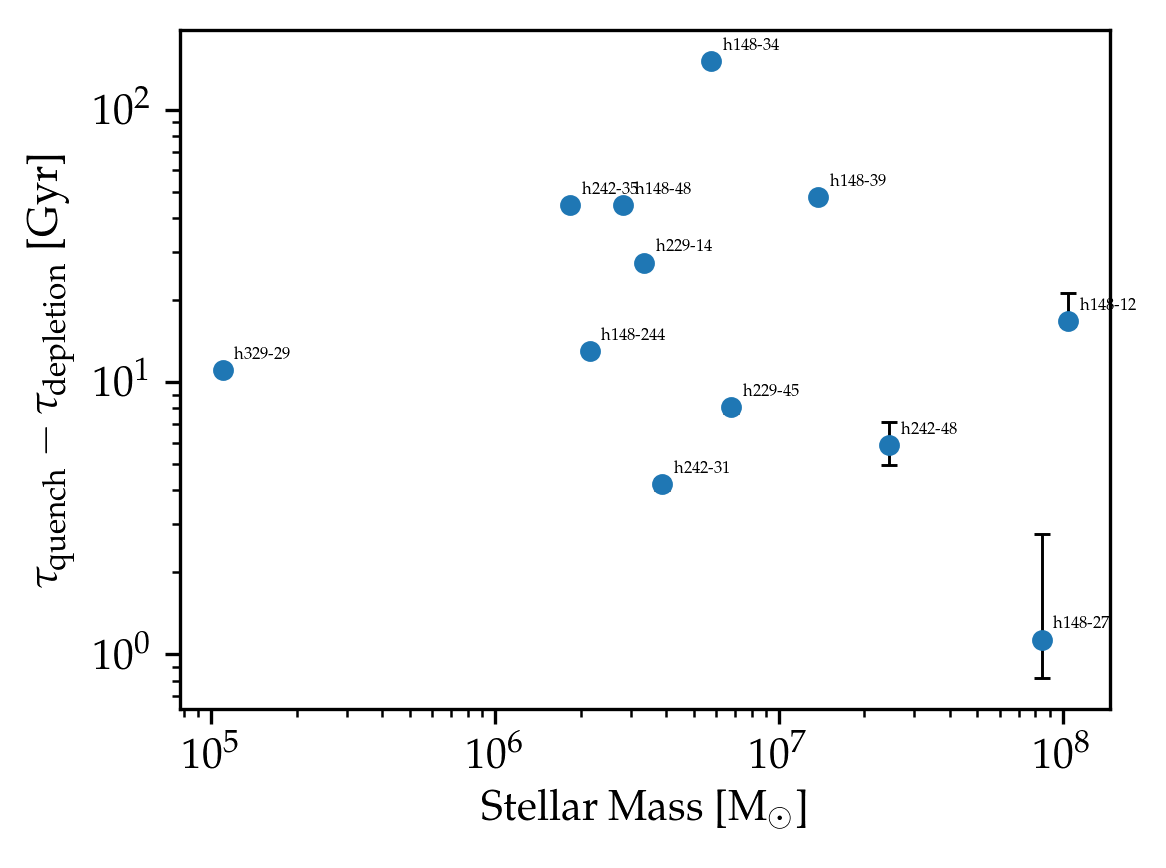

In [129]:
diff_upper_error = np.sqrt(tinfall_upper_err**2 + tquench_upper_err**2)[~np.isinf(depletion_times)]
diff_lower_error = np.sqrt(tinfall_lower_err**2 + tquench_lower_err**2)[~np.isinf(depletion_times)]

diff = np.array(depletion_times)[~np.isinf(depletion_times)]/1e9 - np.array(quenching_timescales)[~np.isinf(depletion_times)]

fig, ax = plt.subplots(1,1,figsize=(4,3),dpi=300)
ax.errorbar(mstar[~np.isinf(depletion_times)],diff,
            yerr = np.array([diff_lower_error, diff_upper_error]),
            fmt='o',
            elinewidth=0.7,
            ecolor='k',
            capsize=2,
            capthick=0.7,
            ms = 4,
            zorder = 10)

for x, (sim, i) in enumerate(zip(sims[~np.isinf(depletion_times)],newids[~np.isinf(depletion_times)])):
    ax.annotate(f'{sim}-{i}',(mstar[~np.isinf(depletion_times)][x]*1.1, diff[x]*1.1), size=4)

ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel(r'$\tau_{\mathrm{depletion}} - \tau_{\mathrm{quench}}$ [Gyr]')

ax.loglog()
plt.show()

In [110]:
n = sims[~np.isinf(depletion_times)]
n[(diff<2)]

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


array(['h148'], dtype='<U4')